The goal of this challenge is to recognize one user amongst all others. Keep in mind that data is highly inbalanced.

Evaluation metrics of this challenge is **ROC AUC**.<br>
<br>

This dataset contains user transitions between pages. The goal of this challenge is to recognize one user amongst all others. The dataset consists of user sessions, each session is a sequence of transitions between pages. A sequence can be one to ten pages long.

- train.csv - contains webpages, timestamps, and targets for each train session.
- test.csv - contains webpages, timestamps for each test session.
- id_map.parquet - webpages id to url map




In [ ]:
# !pip install pyarrow

In [ ]:
#import library

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE


%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
#@title
#File importing method for Jupyter Notebook

# train = pd.read_csv(r'C:\Users\Yvonne_Gan\EPAM\Desktop\00_Homework\\epamdscourseclassification3\train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
# test = pd.read_csv(r'C:\Users\Yvonne_Gan\EPAM\Desktop\00_Homework\\epamdscourseclassification3\test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

# train.head()

In [ ]:
#@title
# parquet_file = pd.read_parquet(r'C:\Users\Yvonne_Gan\EPAM\Desktop\00_Homework\\epamdscourseclassification3\id_map.parquet', engine="auto")

# parquet_file

## Data Inspection

#### Importing the files using mounting Google Drive method and quick overview

In [139]:
# import the files using Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset for training
train = pd.read_csv(r'/content/drive/MyDrive/Official DS training Files/Classification part 3/train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

#Dataset for prediction and submission
test = pd.read_csv(r'/content/drive/MyDrive/Official DS training Files/Classification part 3/test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

#inspect first 5 rows of train dataset
train.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,50150.0,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,659.0,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,425.0,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,451.0,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


In [ ]:
#inspect last 5 rows of train dataset
train.tail()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
159964,117685,2018-04-12 09:06:57,3935.0,2018-04-12 09:07:01,451.0,2018-04-12 09:07:03,828.0,2018-04-12 09:07:03,451.0,2018-04-12 09:07:06,30975.0,2018-04-12 09:07:06,30975.0,2018-04-12 09:07:07,30975.0,2018-04-12 09:07:09,828.0,2018-04-12 09:07:12,828.0,2018-04-12 09:07:13,0
159965,45314,2018-11-25 06:21:54,45314.0,2018-11-25 06:21:58,1985.0,2018-11-25 06:22:03,31716.0,2018-11-25 06:22:04,1530.0,2018-11-25 06:22:13,31716.0,2018-11-25 06:22:16,31716.0,2018-11-25 06:22:28,31716.0,2018-11-25 06:22:40,31716.0,2018-11-25 06:22:52,2076.0,2018-11-25 06:22:53,0
159966,165603,2018-03-12 11:56:15,165603.0,2018-03-12 11:56:16,28947.0,2018-03-12 11:56:16,646.0,2018-03-12 11:56:17,28947.0,2018-03-12 11:56:17,451.0,2018-03-12 11:56:17,330924.0,2018-03-12 11:56:18,28947.0,2018-03-12 11:56:18,451.0,2018-03-12 11:56:18,425.0,2018-03-12 11:56:18,0
159967,34745,2018-09-12 10:00:03,195204.0,2018-09-12 10:00:10,72458.0,2018-09-12 10:00:10,72458.0,2018-09-12 10:01:29,72458.0,2018-09-12 10:01:30,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
159968,10708,2018-12-19 11:15:22,8940.0,2018-12-19 11:15:22,10734.0,2018-12-19 11:15:22,438.0,2018-12-19 11:15:22,659.0,2018-12-19 11:15:22,10708.0,2018-12-19 11:15:23,10734.0,2018-12-19 11:15:23,7562.0,2018-12-19 11:15:23,438.0,2018-12-19 11:15:24,7562.0,2018-12-19 11:15:24,0


In [ ]:
#Inspect train dataset information

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159969 entries, 0 to 159968
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   webpage1   159969 non-null  int64         
 1   time1      159969 non-null  datetime64[ns]
 2   webpage2   157990 non-null  float64       
 3   time2      157990 non-null  datetime64[ns]
 4   webpage3   156066 non-null  float64       
 5   time3      156066 non-null  datetime64[ns]
 6   webpage4   154402 non-null  float64       
 7   time4      154402 non-null  datetime64[ns]
 8   webpage5   152841 non-null  float64       
 9   time5      152841 non-null  datetime64[ns]
 10  webpage6   151324 non-null  float64       
 11  time6      151324 non-null  datetime64[ns]
 12  webpage7   149912 non-null  float64       
 13  time7      149912 non-null  datetime64[ns]
 14  webpage8   148574 non-null  float64       
 15  time8      148574 non-null  datetime64[ns]
 16  webpage9   147160 no

In [ ]:
#Inspect the shape (number of rows & columns) of the train dataset

train.shape

(159969, 21)

In [ ]:
#Inspect missing values in the train dataset

train.isna().sum()

webpage1         0
time1            0
webpage2      1979
time2         1979
webpage3      3903
time3         3903
webpage4      5567
time4         5567
webpage5      7128
time5         7128
webpage6      8645
time6         8645
webpage7     10057
time7        10057
webpage8     11395
time8        11395
webpage9     12809
time9        12809
webpage10    14113
time10       14113
target           0
dtype: int64

In [ ]:
#Inspect how many duplicated rows in the train dataset
train.duplicated().sum()

16

Given the duplicated rows are so little compared to the dataset's total size. It probably makes no difference to clean up these rows. Therefore decided not to take action to remove these rows.

In [ ]:
#Parquet file with the information of website URL according to the webpage id in train dataset
parquet_file = pd.read_parquet(r'/content/drive/MyDrive/Official DS training Files/Classification part 3/id_map.parquet', engine="auto")

parquet_file

,id,webpage
0,326127,www.abmecatronique.com
1,182113,groups.live.com
2,551820,majeureliguefootball.wordpress.com
3,401995,cdt46.media.tourinsoft.eu
4,105504,www.hdwallpapers.eu
...,...,...
48366,386746,i1-js-14-3-01-11074-747051290-i.init.cedexis-radar.net
48367,530474,i1-js-14-3-01-12434-548464295-i.init.cedexis-radar.net
48368,142359,embed.api.tv
48369,520516,n-tennis.fr


## Data Prepping & Cleaning 
- Retrieving, creating and finalizing the useful data information
- Then set up these new dataset with new useful information/values into new dataframe

In [ ]:
#Split the train dataset into 2 for next action
df_target = train.target
df_train = train.drop(columns='target')

In [ ]:
# Prepare, retrieve, create and finalizing the useful data information to form a new dataframe

def preproc(df):
    return (
        df.assign(
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.filter(like='webpage').isna().sum(axis=1),
            
            # number of unique pages in session
            n_unique_pages=lambda x: 
                x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
                        
            # hour of day in a session
            hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).astype(int),

            # day of day in a session
            day=lambda x: x.filter(like='time').apply(lambda x: x.dt.day).mean(axis=1).astype(int),
            
            #month of day in a session
            month=lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1).astype(int),
            
            #year of day in a session
            year=lambda x: x.filter(like='time').apply(lambda x: x.dt.year).mean(axis=1).astype(int),
            
            # day of week in a session, Monday = 0
            day_of_week=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).astype(int),
                        
            # difference between 10th page and 1st in seconds
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            
            #total minutes spent
            minutes_spent = lambda x: (x.time10 - x.time1).dt.total_seconds()/60,          
            
        )
        # drop time columns
        .drop(columns=[f'time{i+1}' for i in range(10)])
        # fill missing pages with zeros
        .fillna(0)
    )
    
    
    
df_train = preproc(df_train)
df_test = preproc(test)

In [ ]:
#Inspect the first 5 rows of new training dataset
df_train.head()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent,target
session_id,,,,,,,,,,,,,,,,,,,,
0,9486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1,5,20,2,2019,2,0.0,0.000000,0
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,0,7,7,22,2,2019,4,26.0,0.433333,0
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,0,4,12,16,12,2018,6,7.0,0.116667,0
3,10591,451.0,77580.0,227821.0,633.0,425.0,10591.0,227834.0,227834.0,227834.0,0,7,12,13,2,2019,2,102.0,1.700000,0
4,438,425.0,529.0,65685.0,187638.0,451.0,425.0,65685.0,187625.0,187625.0,0,7,6,12,4,2018,3,6.0,0.100000,0


In [ ]:
#Inspect the last 5 rows of new training dataset
df_train.tail()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent,target
session_id,,,,,,,,,,,,,,,,,,,,
159964,117685,3935.0,451.0,828.0,451.0,30975.0,30975.0,30975.0,828.0,828.0,0,5,9,12,4,2018,3,16.0,0.266667,0
159965,45314,45314.0,1985.0,31716.0,1530.0,31716.0,31716.0,31716.0,31716.0,2076.0,0,5,6,25,11,2018,6,59.0,0.983333,0
159966,165603,165603.0,28947.0,646.0,28947.0,451.0,330924.0,28947.0,451.0,425.0,0,6,11,12,3,2018,0,3.0,0.050000,0
159967,34745,195204.0,72458.0,72458.0,72458.0,0.0,0.0,0.0,0.0,0.0,5,3,10,12,9,2018,2,0.0,0.000000,0
159968,10708,8940.0,10734.0,438.0,659.0,10708.0,10734.0,7562.0,438.0,7562.0,0,6,11,19,12,2018,2,2.0,0.033333,0


In [ ]:
#Adding the Target to the last column in order to have a full dataset for next EDA portion
df_train["target"] = df_target
df_train

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent,target
session_id,,,,,,,,,,,,,,,,,,,,
0,9486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1,5,20,2,2019,2,0.0,0.000000,0
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,0,7,7,22,2,2019,4,26.0,0.433333,0
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,0,4,12,16,12,2018,6,7.0,0.116667,0
3,10591,451.0,77580.0,227821.0,633.0,425.0,10591.0,227834.0,227834.0,227834.0,0,7,12,13,2,2019,2,102.0,1.700000,0
4,438,425.0,529.0,65685.0,187638.0,451.0,425.0,65685.0,187625.0,187625.0,0,7,6,12,4,2018,3,6.0,0.100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159964,117685,3935.0,451.0,828.0,451.0,30975.0,30975.0,30975.0,828.0,828.0,0,5,9,12,4,2018,3,16.0,0.266667,0
159965,45314,45314.0,1985.0,31716.0,1530.0,31716.0,31716.0,31716.0,31716.0,2076.0,0,5,6,25,11,2018,6,59.0,0.983333,0
159966,165603,165603.0,28947.0,646.0,28947.0,451.0,330924.0,28947.0,451.0,425.0,0,6,11,12,3,2018,0,3.0,0.050000,0


In [ ]:
# The new shape of the training dataset
df_train.shape

(159969, 20)

In [ ]:
# Overview of the new the training dataset information/data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159969 entries, 0 to 159968
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   webpage1         159969 non-null  int64  
 1   webpage2         159969 non-null  float64
 2   webpage3         159969 non-null  float64
 3   webpage4         159969 non-null  float64
 4   webpage5         159969 non-null  float64
 5   webpage6         159969 non-null  float64
 6   webpage7         159969 non-null  float64
 7   webpage8         159969 non-null  float64
 8   webpage9         159969 non-null  float64
 9   webpage10        159969 non-null  float64
 10  nans_count       159969 non-null  int64  
 11  n_unique_pages   159969 non-null  int64  
 12  hour             159969 non-null  int64  
 13  day              159969 non-null  int64  
 14  month            159969 non-null  int64  
 15  year             159969 non-null  int64  
 16  day_of_week      159969 non-null  int6

In [ ]:
# Overview of the max, min, percentile etc using describe
df_train.iloc[:,10:19].describe()

,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent
count,159969.000000,159969.000000,159969.000000,159969.000000,159969.000000,159969.000000,159969.000000,159969.000000,159969.000000
mean,0.472567,5.753540,8.282117,18.030737,5.235983,2018.533572,2.273578,110.306616,1.838444
std,1.704873,2.404623,3.209507,7.156466,4.507342,0.498873,1.995245,249.285987,4.154766
min,0.000000,1.000000,3.000000,1.000000,1.000000,2018.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,6.000000,12.000000,2.000000,2018.000000,1.000000,4.000000,0.066667
50%,0.000000,6.000000,8.000000,19.000000,2.000000,2019.000000,2.000000,20.000000,0.333333
75%,0.000000,8.000000,11.000000,24.000000,11.000000,2019.000000,4.000000,81.000000,1.350000
max,9.000000,10.000000,19.000000,31.000000,12.000000,2019.000000,6.000000,1800.000000,30.000000


In [ ]:
#Taking a look of the correlation of the training dataset
df_train.corr()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent,target
webpage1,1.000000,0.524058,0.510404,0.486268,0.462719,0.446626,0.438364,0.425082,0.409994,0.398545,-0.055418,-0.042645,-0.008818,-0.017019,-0.014328,-0.002588,-0.001748,-0.043182,-0.043182,-0.006286
webpage2,0.524058,1.000000,0.540165,0.509591,0.488884,0.472771,0.451314,0.439723,0.420095,0.412553,-0.067968,-0.045704,-0.010913,-0.014991,-0.012516,-0.003976,-0.005287,-0.044505,-0.044505,-0.007030
webpage3,0.510404,0.540165,1.000000,0.538426,0.512098,0.484044,0.466601,0.453081,0.433012,0.423449,-0.081884,-0.042449,-0.010925,-0.016319,-0.014618,-0.000322,-0.005059,-0.047086,-0.047086,-0.008945
webpage4,0.486268,0.509591,0.538426,1.000000,0.536678,0.507290,0.488505,0.469669,0.449775,0.437020,-0.093864,-0.040942,-0.012534,-0.018794,-0.013380,-0.002753,-0.001570,-0.046675,-0.046675,-0.007597
webpage5,0.462719,0.488884,0.512098,0.536678,1.000000,0.531183,0.510161,0.489106,0.460459,0.445551,-0.101690,-0.037419,-0.011319,-0.018199,-0.013873,-0.001506,-0.002558,-0.046926,-0.046926,-0.009751
webpage6,0.446626,0.472771,0.484044,0.507290,0.531183,1.000000,0.531899,0.512368,0.479616,0.465485,-0.110799,-0.037238,-0.011131,-0.014408,-0.017516,0.000259,-0.005371,-0.047299,-0.047299,-0.009138
webpage7,0.438364,0.451314,0.466601,0.488505,0.510161,0.531899,1.000000,0.534372,0.507962,0.486498,-0.116210,-0.034928,-0.010971,-0.018785,-0.018274,0.000506,-0.004857,-0.046892,-0.046892,-0.008563
webpage8,0.425082,0.439723,0.453081,0.469669,0.489106,0.512368,0.534372,1.000000,0.529323,0.505448,-0.120484,-0.031655,-0.012095,-0.018227,-0.016576,0.000634,-0.004992,-0.046038,-0.046038,-0.008649
webpage9,0.409994,0.420095,0.433012,0.449775,0.460459,0.479616,0.507962,0.529323,1.000000,0.532802,-0.123002,-0.023695,-0.014250,-0.020640,-0.014054,-0.000893,-0.004607,-0.043148,-0.043148,-0.009511
webpage10,0.398545,0.412553,0.423449,0.437020,0.445551,0.465485,0.486498,0.505448,0.532802,1.000000,-0.124047,-0.019817,-0.012777,-0.017346,-0.016734,0.001923,-0.005439,-0.039201,-0.039201,-0.007121


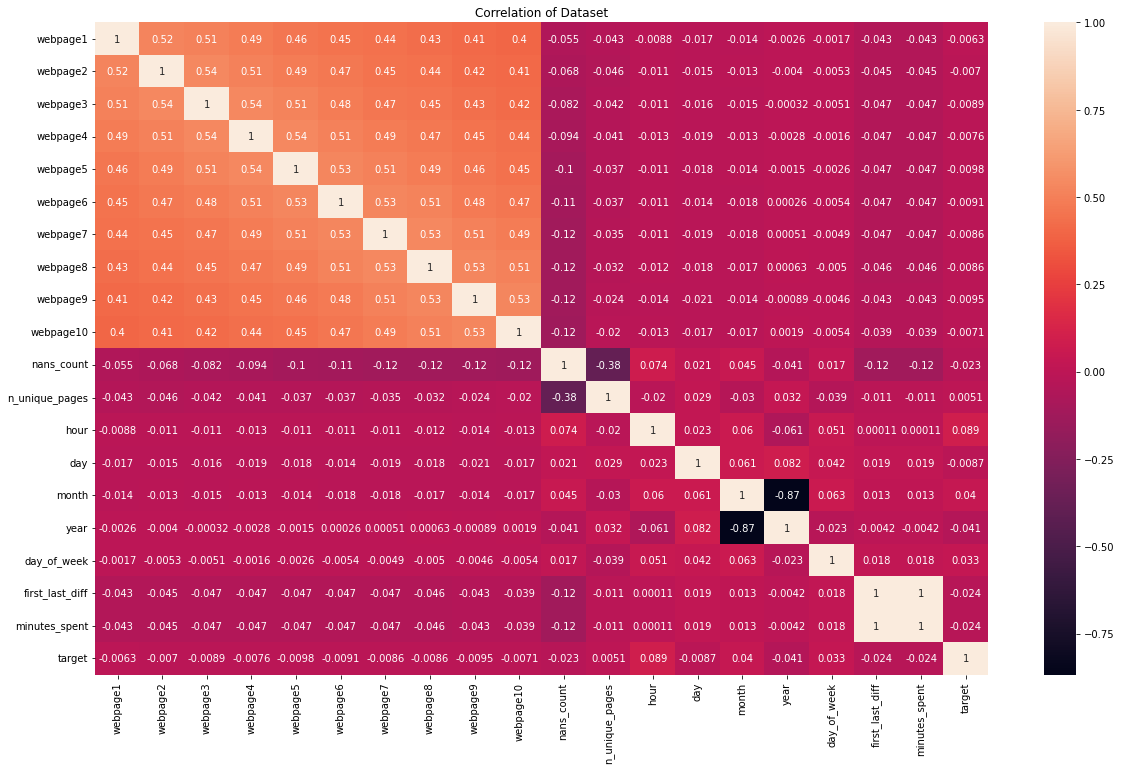

In [ ]:
# Plot heatmap for data visualization on the correlation for a more visual friendly inspection
fig = plt.figure(figsize=(20,12))

ax = sns.heatmap(df_train.corr(), annot=True)
ax.set_title("Correlation of Dataset")

plt.show()

In [ ]:
#List of Unique Values for an overview
for i in df_train.iloc[:,10:]:
    counts = df_train[i].value_counts()
    print("Number of value counts in column",i,":\n",counts,"\n")

Number of value counts in column nans_count :
 0    145856
9      1979
8      1924
7      1664
6      1561
5      1517
2      1414
4      1412
3      1338
1      1304
Name: nans_count, dtype: int64 

Number of value counts in column n_unique_pages :
 7     24910
6     24083
8     21796
5     21043
4     15129
9     14472
3     12103
2     11317
1      8770
10     6346
Name: n_unique_pages, dtype: int64 

Number of value counts in column hour :
 5     20936
6     19133
10    17718
4     17518
7     15634
9     14980
11    14101
8     12674
12    11820
13     7681
14     2167
17     1244
18     1072
19      884
15      837
16      835
3       735
Name: hour, dtype: int64 

Number of value counts in column day :
 12    29373
4     12767
19    11229
26    10516
20     9930
25     9498
18     8567
22     8389
13     7964
21     7032
29     6406
17     6218
24     5271
27     5143
15     3782
14     3697
28     3586
16     3044
30     1906
31     1893
23     1369
3      1212
2      1094
5   

## EDA

In [ ]:
#Functions for Plot Setting

#For axis labels naming and plot title
def set_ax(ax,x_name, y_name, title_name):

    ax.set_xlabel(x_name, size=12)
    ax.set_ylabel(y_name, size=12)
    ax.set_title(title_name, fontsize=14)
    
#For value indication    
def plot_feature(ax_plot):
    for value in ax_plot.patches:
        height = value.get_height()
        ax_plot.annotate(f'{int(height)}', xy=(value.get_x()+value.get_width()/2, height), 
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

In [ ]:
#Checking the numbers of value on the target variable/target classes
df_train["target"].value_counts()

0    158394
1      1575
Name: target, dtype: int64

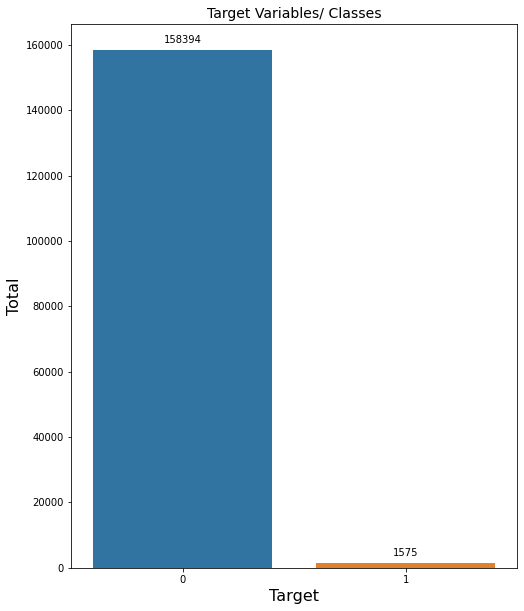

In [ ]:
#Review Target Variable in visualization for better comparison
fig = plt.figure(figsize=(8,10))

ax = sns.countplot(x="target", data=df_train)

plot_feature(ax)

plt.xlabel("Target", size=16)
plt.ylabel("Total", size=16)

 
# title    
plt.title("Target Variables/ Classes", fontsize=14)


plt.show()

As we can see from the countplot above, our dataset is largely imbalanced dataset. We will need to do something about it during model training

Following are plots of each features to analyze how kind of information or story this dataset can share with us

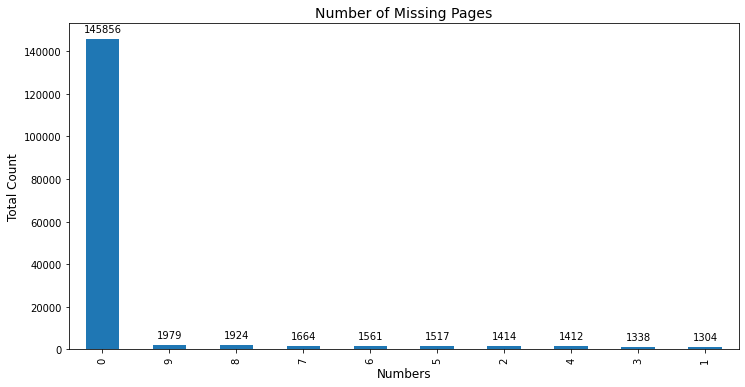

In [ ]:
fig = plt.figure(figsize=(12,6))

# ax1 - 1st plot for Number of Missing Pages 
ax1a = df_train["nans_count"].value_counts().plot(kind = 'bar')
plot_feature(ax1a)
set_ax(ax1a,"Numbers","Total Count", "Number of Missing Pages")

plt.show()

The first plot here shows the Number of Missing Pages per user. We can see a significant difference between zero (0) and other values. The Zero represents a user who visited recorded 10 web pages during their session, comprising up to 90% of the dataset.

To have a better look of the distribution, we dropped Zero value in the plot below and to see the margin between missing pages from 1 to 9.

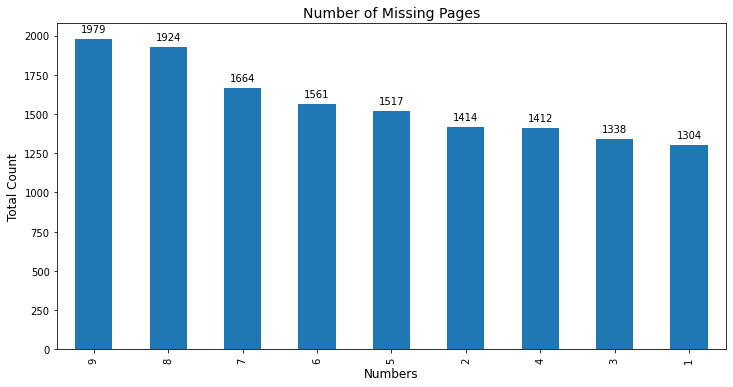

In [ ]:
fig = plt.figure(figsize=(12,6))

# ax1 - 1st plot for Number of Missing Pages
ax1b = df_train["nans_count"].value_counts().drop(0).plot(kind = 'bar')
plot_feature(ax1b)
set_ax(ax1b,"Numbers","Total Count", "Number of Missing Pages")

plt.show()

We could see here that the actually quite close but we are still looking at 1979 of users who turned offline after visited 1 webpage only from our dataset.

Next up we have plot for Number of Unique Pages. This plot is to show us on each user, how many unique pages, whether the user revisiting the same web pages over and over among the 10 web pages or visiting 10 all different web pages.

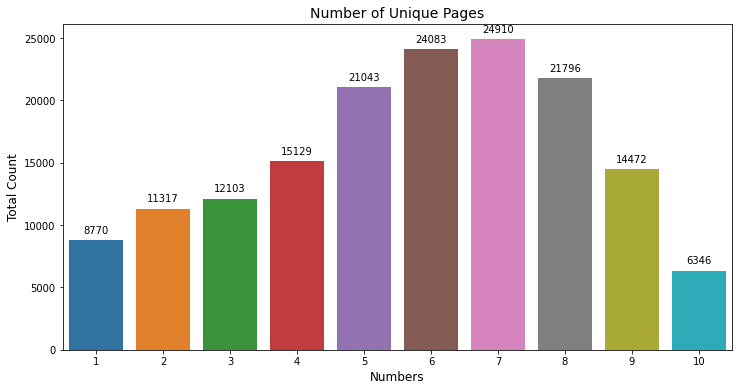

In [ ]:
fig = plt.figure(figsize=(12,6))

# ax2 - 2nd plot for Number of Unique Pages
ax2 = sns.countplot(x=df_train["n_unique_pages"])
plot_feature(ax2)
set_ax(ax2,"Numbers","Total Count", "Number of Unique Pages")


plt.show()

From this plot, we can see that up to 24910 users have visited 7 unique pages. This means, among the 10 web pages, the user revisited at least one previously browsed website again throughout the entire session.

Surprisingly the number of unique pages of 10, which means users visited 10 different web pages are relatively low.

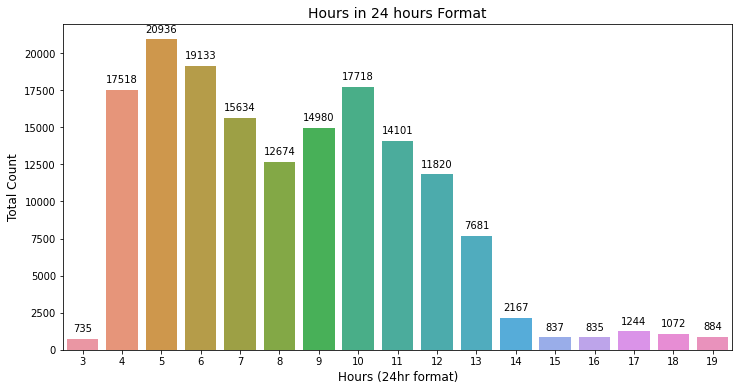

In [ ]:
fig = plt.figure(figsize=(12,6))

# ax3 - 3rd plot for Number of Hour
ax3 = sns.countplot(x=df_train["hour"])
plot_feature(ax3)
set_ax(ax3,"Hours (24hr format)","Total Count", "Hours in 24 hours Format")

plt.show()

In this hour plot, it shows that in which hours the user spent the time to have an online browsing session. Surprisingly on around 5am (As the hours are in 24hr format) is the highest time where users visiting web pages. 

It may be due to time differences but we are unable to confirm as the dataset did not indicated the countries/regions of this user.

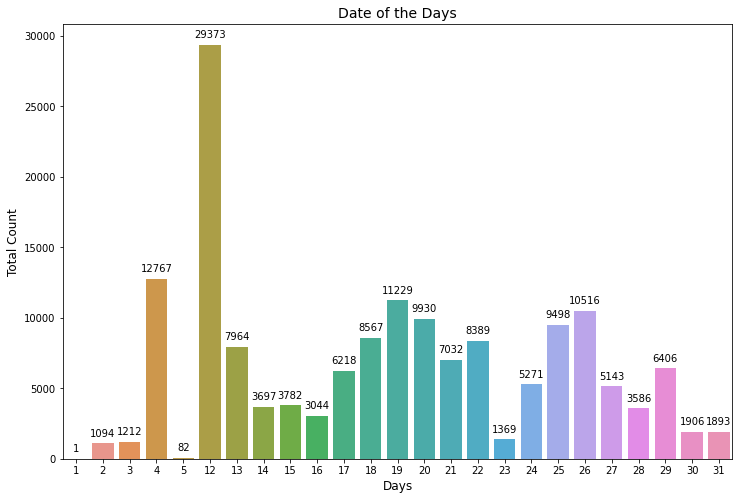

In [ ]:
fig = plt.figure(figsize=(12,8))

# ax4 - 4th plot for Date of the Day
ax4 = sns.countplot(x=df_train["day"])
plot_feature(ax4)
set_ax(ax4,"Days","Total Count", "Date of the Days")


plt.show()

In this Date of the Days plot, this is the date within a month and we get to see the distribution of users on which particular date has more browsing activities.

From the data visualization we can see on the 12th of the month, it is the highest date of the days/ day of the month where up to 29373 users having online browsing activity.

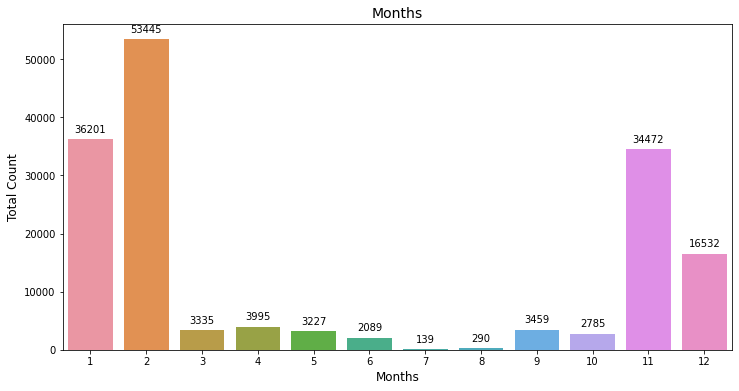

In [ ]:
fig = plt.figure(figsize=(12,6))

# ax5 - 5th plot for Months
ax5 = sns.countplot(x=df_train["month"])
plot_feature(ax5)
set_ax(ax5,"Months","Total Count", "Months")

plt.show()

And next, we see the Month of our user's browsing activities. We could see in January, February, November and December. What could be why only these 4 months have a large amount of user internet browsing activities?

Think about it, November and December are probably due to Thanksgiving and Christmas Holiday seasons. Whereas for January and February, it has to depend on the locations or the culture of the user, it could be either New Year Holiday, postseason promotions, extended long/school holidays)

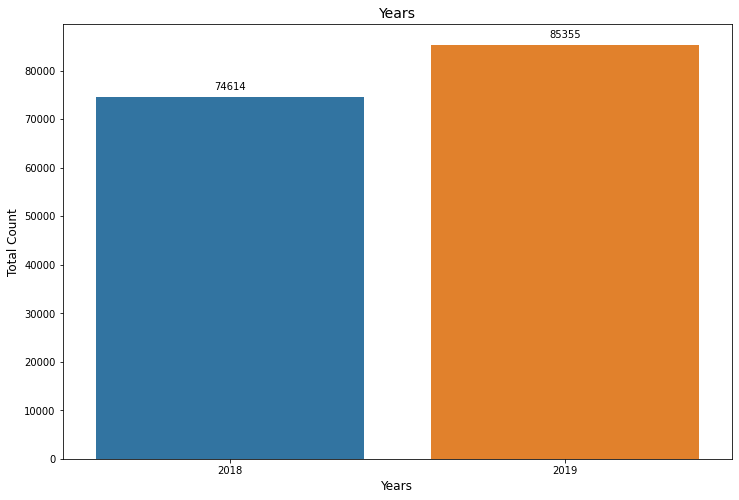

In [ ]:
fig = plt.figure(figsize=(12,8))

# ax6 - 6th plot for Years
ax6 = sns.countplot(x=df_train["year"])
plot_feature(ax6)
set_ax(ax6,"Years","Total Count", "Years")

plt.show()

From the year plot, we can see our dataset is collected between 2018 to 2019 only.

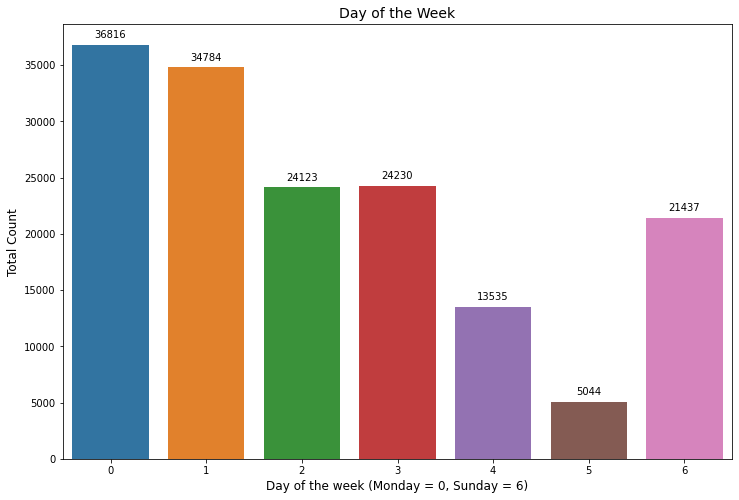

In [ ]:
fig = plt.figure(figsize=(12,8))

# ax7 - 7th plot for Day of the Week
ax7 = sns.countplot(x=df_train["day_of_week"])
plot_feature(ax7)
set_ax(ax7,"Day of the week (Monday = 0, Sunday = 6)","Total Count", "Day of the Week")


plt.show()

Here we have the Day of the Week plot. These value represent Monday as Zero(0) and all the way to Sunday as 6. We can see that Monday and Tuesday comprises most of the users that browsing internet/web pages.

Which makes us wonder what are the status of these users, are they Blue Collar? Students? Young Adults? where they are able to browse internet during the weekdays.

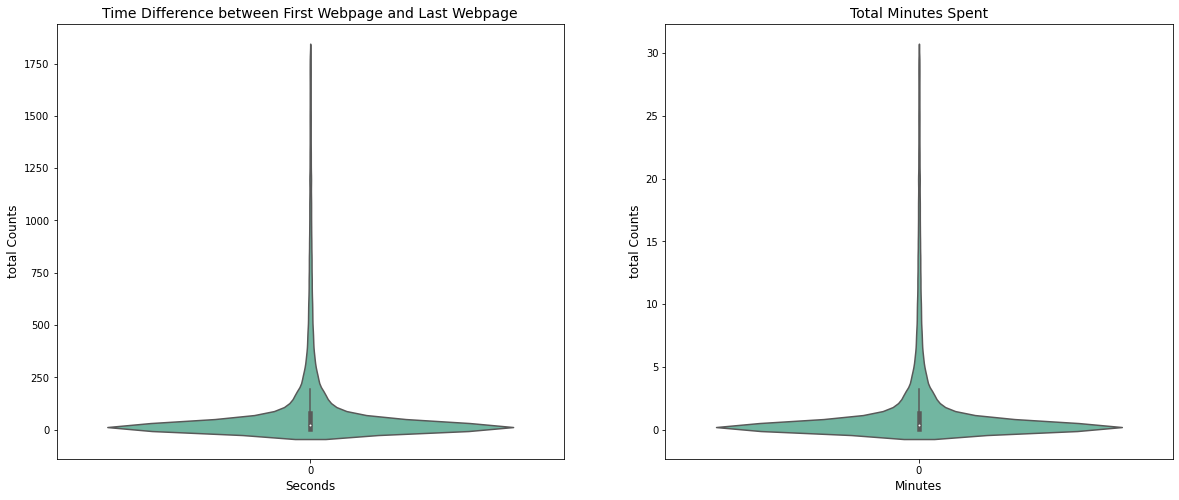

In [ ]:
#Plot boxplot 
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax8 = sns.violinplot(data=df_train["first_last_diff"], palette="Set2", ax=ax[0])
set_ax(ax8, "Seconds", "total Counts", "Time Difference between First Webpage and Last Webpage" )


ax9 = sns.violinplot(data=df_train["minutes_spent"], palette="Set2", ax=ax[1])
set_ax(ax9, "Minutes", "total Counts", "Total Minutes Spent" )

plt.show()

Here is the boxplot for the time spent in Seconds (plot on the left) and Minutes (plot on the right). I converted the minute values from the Seconds values; therefore, the boxplot looks identical. 

The main reason is to make sure there aren't any odd outcomes during the conversion and review them side-by-side to understand that the majority of the user session is spent within Zero (0) to 250 seconds, which in other work is approximately up to 5 minutes. 

It is considered relatively short, but it doesn't mean they visited 10 web pages at 1 go. Some of the users could have only seen 2 - 5 web pages during their user session in these time frames.

Below is the plot chart in histogram, we can clearly see the distribution skew towards the left hand side, under 250 Seconds or 5 minutes.

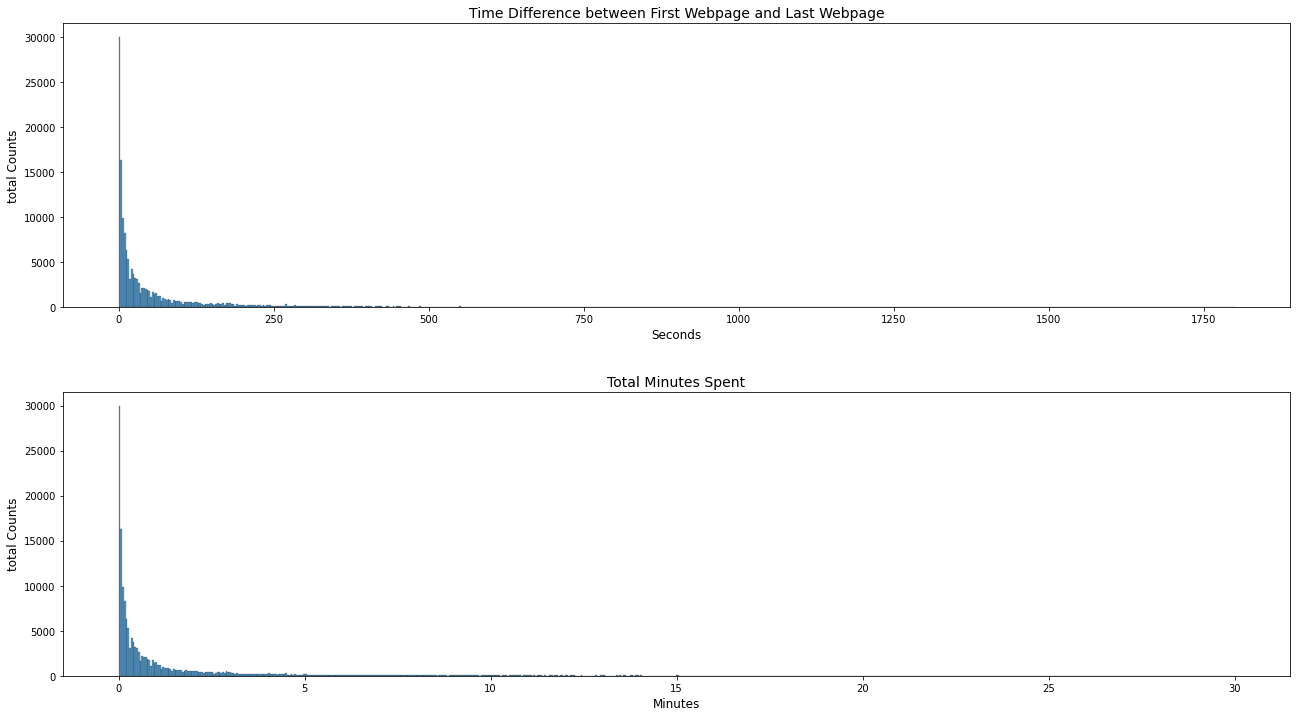

In [ ]:
#Plot histplot 
fig, ax = plt.subplots(2,1,figsize=(22,12))

ax10 = sns.histplot(data=df_train["first_last_diff"], palette="Set2", ax=ax[0])
set_ax(ax10, "Seconds", "total Counts", "Time Difference between First Webpage and Last Webpage" )


ax11 = sns.histplot(data=df_train["minutes_spent"], palette="Set2", ax=ax[1])
set_ax(ax11, "Minutes", "total Counts", "Total Minutes Spent" )

plt.subplots_adjust(hspace=.3) 

plt.show()

In this Month vs Year plot, we can have a clear vision of the time frame of our dataset was collected from January 2018 up to February 2019.

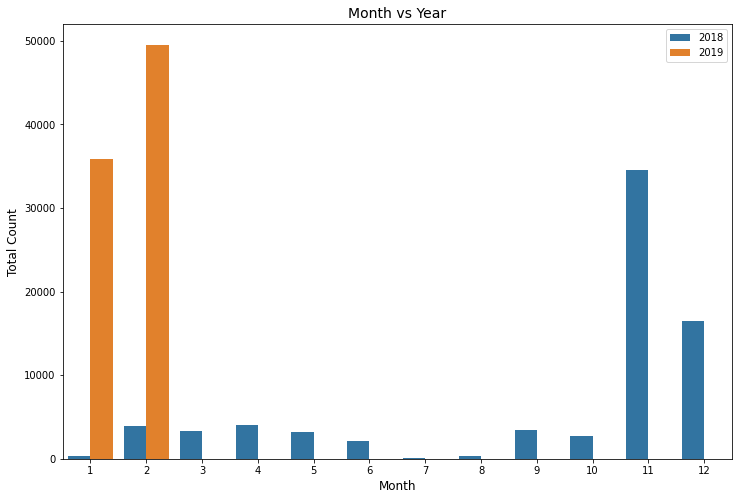

In [130]:
fig =plt.figure(figsize=(12,8))

ax14 = sns.countplot(x="month", hue="year", data= df_train)
ax14.legend(loc='upper right')
set_ax(ax14,"Month","Total Count", "Month vs Year")

plt.show()


As I were to analyze the relationship for Target Classes with other features, here are the few features I attempted to make comparison with our Target Classes.

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


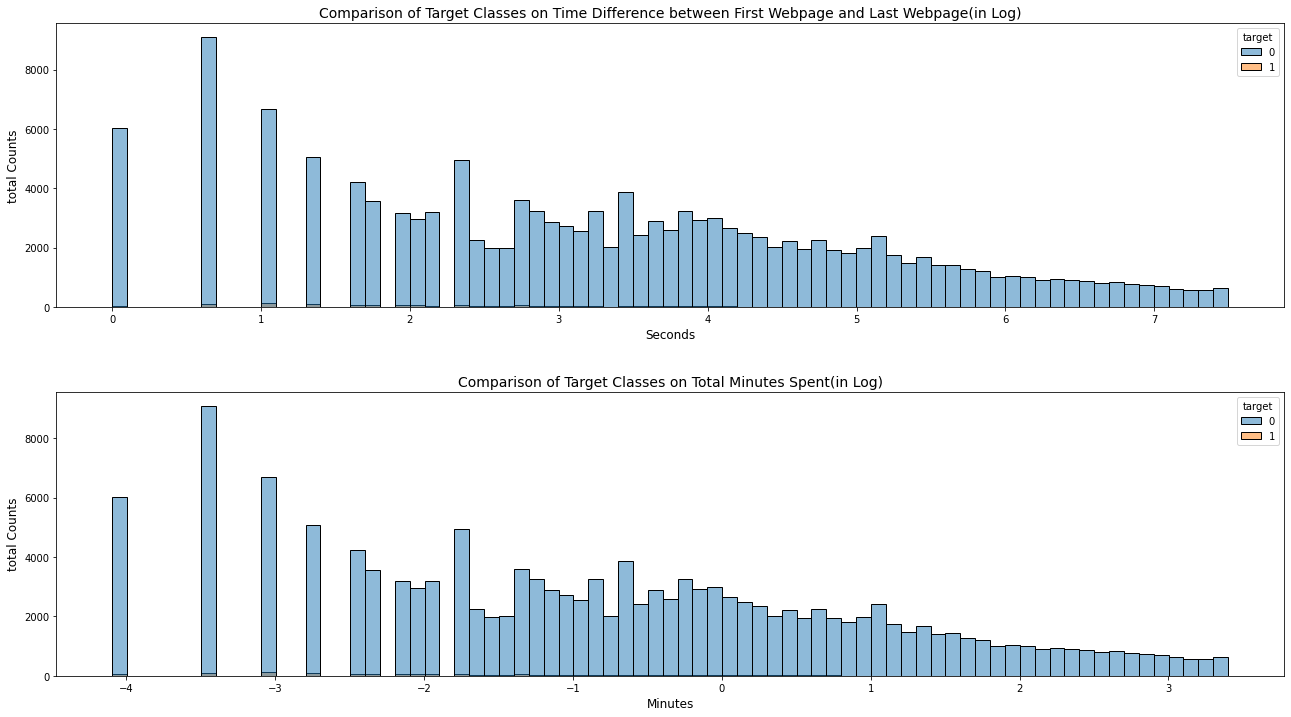

In [ ]:
#Plot histplot 
fig, ax = plt.subplots(2,1,figsize=(22,12))



ax12 = sns.histplot(x=np.log(df_train.first_last_diff),hue="target", data = df_train, ax=ax[0])
set_ax(ax12, "Seconds", "total Counts", "Comparison of Target Classes on Time Difference between First Webpage and Last Webpage(in Log)" )


ax13 = sns.histplot(x=np.log(df_train.minutes_spent),hue="target", data = df_train, ax=ax[1])
set_ax(ax13, "Minutes", "total Counts", "Comparison of Target Classes on Total Minutes Spent(in Log)" )

plt.subplots_adjust(hspace=.3) 

plt.show()

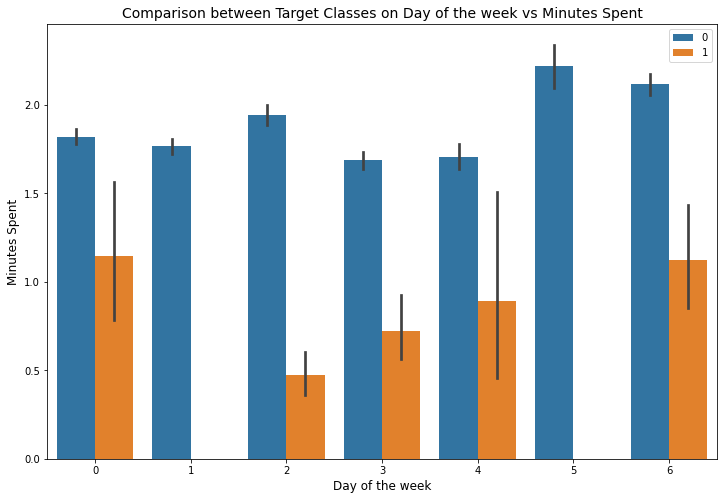

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax15 = sns.barplot(data=df_train, x="day_of_week", y="minutes_spent", hue="target")


set_ax(ax15,"Day of the week","Minutes Spent", "Comparison between Target Classes on Day of the week vs Minutes Spent")
ax15.legend(loc='upper right')

plt.show()

<Figure size 2880x2304 with 0 Axes>

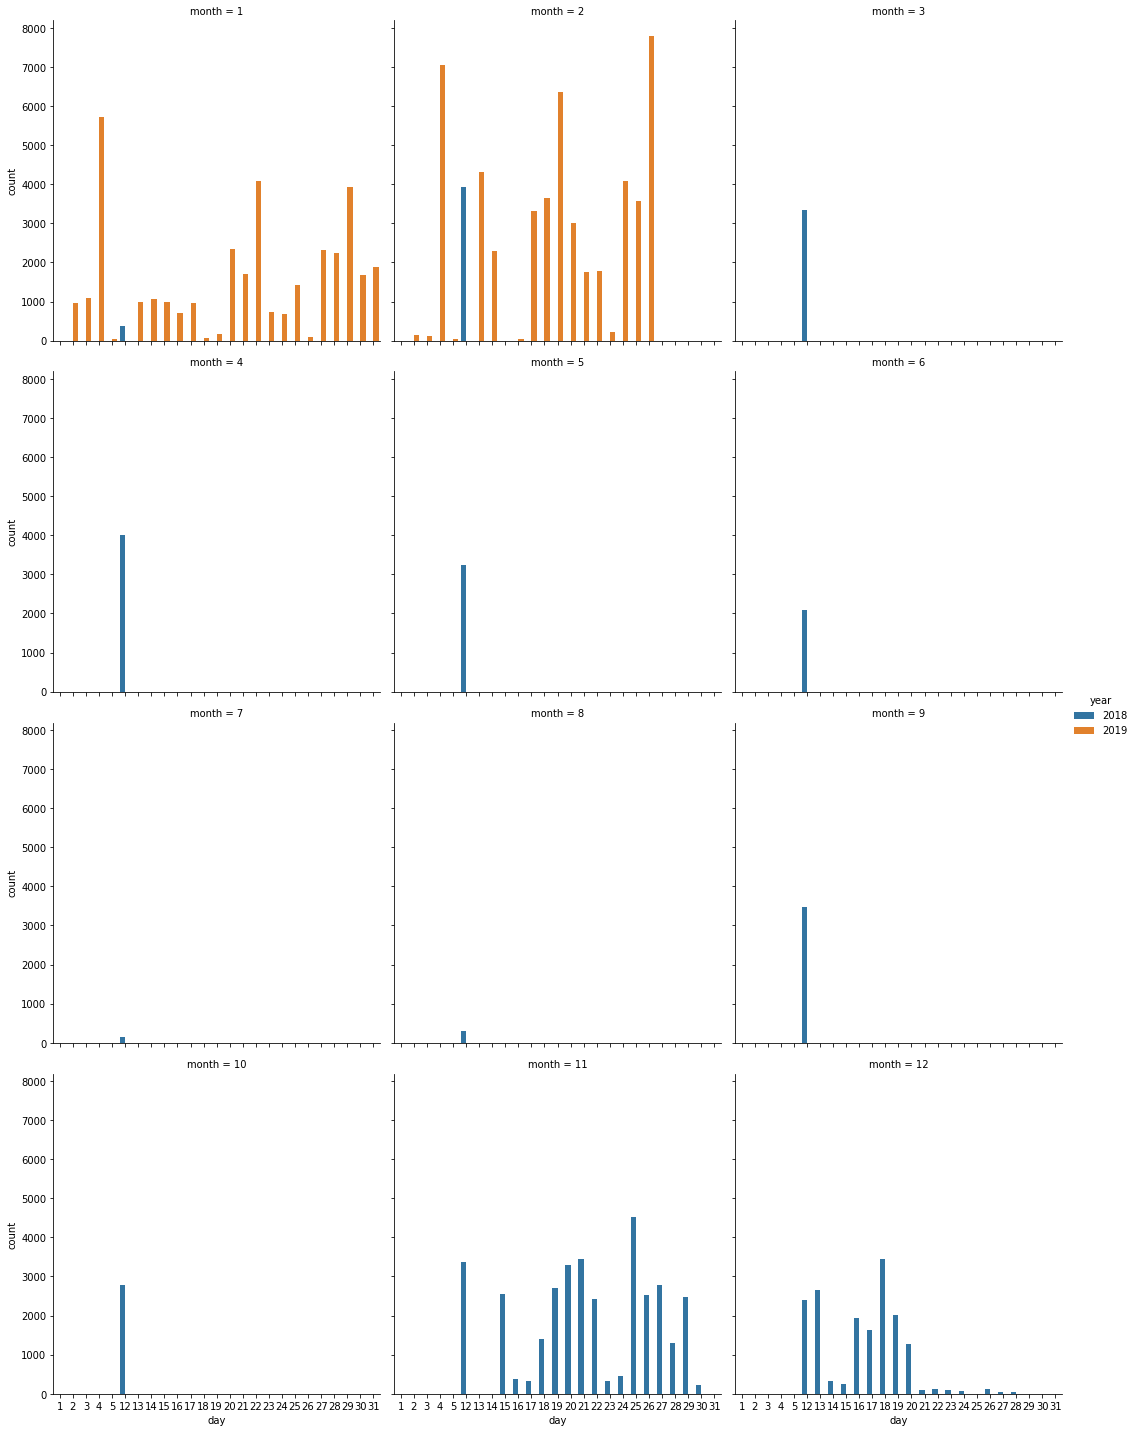

In [ ]:
fig = plt.figure(figsize=(40,32))

ax13 = sns.catplot(x="day",hue="year", data= df_train,
                   col="month", col_wrap=3, kind="count")

<Figure size 2880x2304 with 0 Axes>

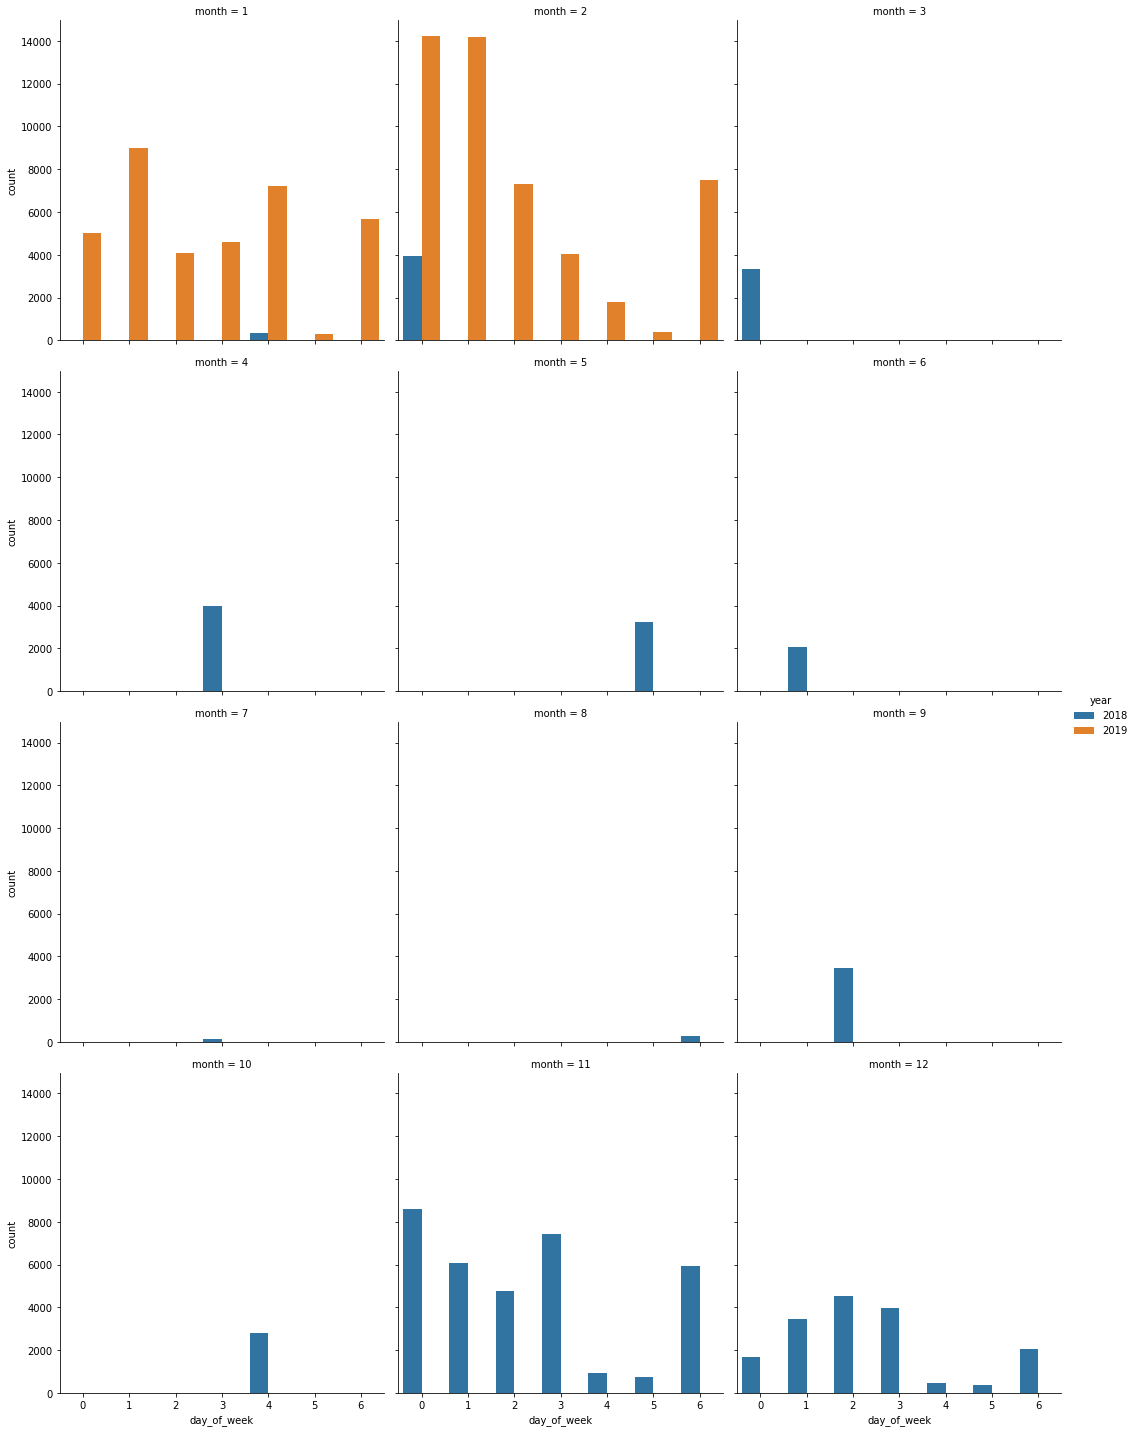

In [ ]:
fig = plt.figure(figsize=(40,32))

ax14 = sns.catplot(x="day_of_week",hue="year", data= df_train,
                   col="month", col_wrap=3, kind="count")

#### EDA of the top and least common websites browsed by users

In [ ]:
#finding top common visited webpage by the users
common = df_train.iloc[:,0:10]

flat_list = []

for sub in common:
    for item in common[sub]:
#         print(item)
#         for x in item:
        flat_list.append(item)
    
    
# flat_list

In [ ]:
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(11)

top_common = Most_Common(flat_list)
top_common = pd.DataFrame(top_common, columns=["id","count"])

top_common


,id,count
0,425.0,80851
1,0.0,75596
2,451.0,59169
3,438.0,38421
4,529.0,35695
5,2323.0,28693
6,10708.0,24969
7,828.0,23438
8,1192.0,23162
9,7562.0,20853


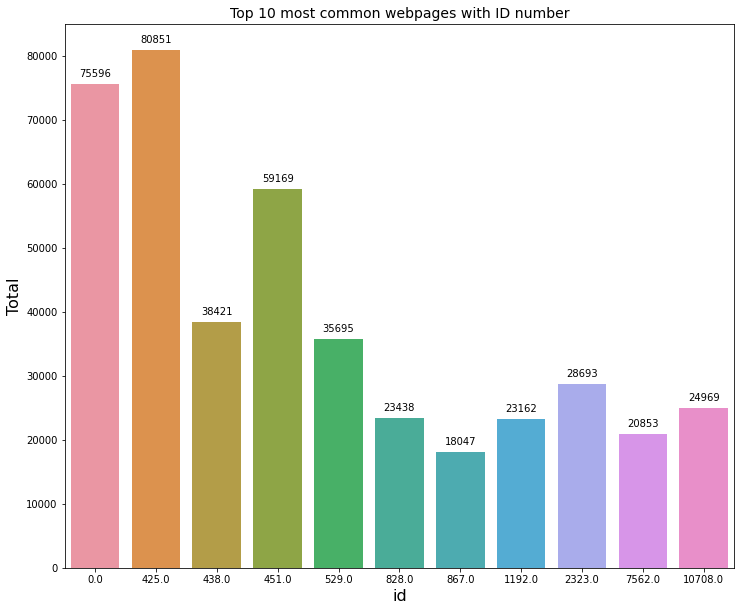

In [ ]:
#Review them in visualization for better comparison
fig15 = plt.figure(figsize=(12,10))

ax15= sns.barplot(x="id", y="count", data=top_common)

plot_feature(ax15)


plt.xlabel("id", size=16)
plt.ylabel("Total", size=16)

 
# title    
plt.title("Top 10 most common webpages with ID number", fontsize=14)


plt.show()


In [ ]:
top_common.insert(2, 'webpage', top_common['id'].map(parquet_file.set_index('id')['webpage']))

In [ ]:
top_common

,id,count,webpage
0,425.0,80851,www.google.fr
1,0.0,75596,NaN
2,451.0,59169,www.google.com
3,438.0,38421,apis.google.com
4,529.0,35695,www.facebook.com
5,2323.0,28693,www.bing.com
6,10708.0,24969,mail.google.com
7,828.0,23438,clients1.google.com
8,1192.0,23162,s.youtube.com
9,7562.0,20853,plus.google.com


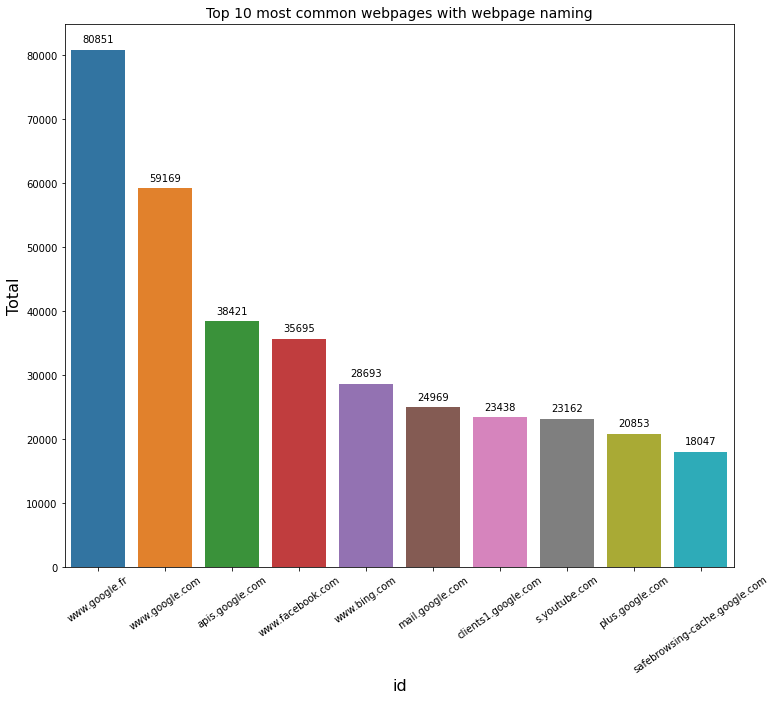

In [ ]:
#Review them in visualization for better comparison
fig16 = plt.figure(figsize=(12,10))

ax16 = sns.barplot(x="webpage", y="count", data=top_common)

plot_feature(ax16)

plt.xlabel("id", size=16)
plt.xticks(rotation=35, fontsize=10,horizontalalignment='center')
plt.ylabel("Total", size=16)


# title    
plt.title("Top 10 most common webpages with webpage naming", fontsize=14)


plt.show()

In [ ]:

def Least_Common(array):
    least = Counter(array)
    n = 11
    return least.most_common()[:-n-1:-1]


least_common = Least_Common(flat_list)
least_common = pd.DataFrame(least_common, columns=["id","count"])

least_common

,id,count
0,56676.0,1
1,218474.0,1
2,9785.0,1
3,224337.0,1
4,430166.0,1
5,98263.0,1
6,455230.0,1
7,396262.0,1
8,501198.0,1
9,233047.0,1


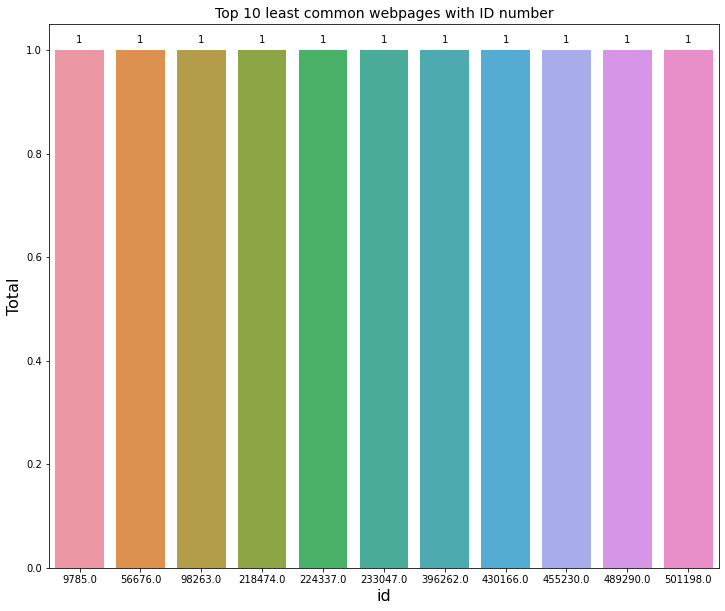

In [ ]:
#Review them in visualization for better comparison
fig17 = plt.figure(figsize=(12,10))

ax17 = sns.barplot(x="id", y="count", data=least_common)

plot_feature(ax17)


plt.xlabel("id", size=16)
plt.ylabel("Total", size=16)

 
# title    
plt.title("Top 10 least common webpages with ID number", fontsize=14)


plt.show()


In [ ]:
least_common.insert(2, 'webpage', least_common['id'].map(parquet_file.set_index('id')['webpage']))

In [ ]:
least_common

,id,count,webpage
0,56676.0,1,www.vic38.fr
1,218474.0,1,de-wimg5.ask.fm
2,9785.0,1,assets.entrepotnumerique.com
3,224337.0,1,blog.touret.info
4,430166.0,1,i1-js-14-3-01-11074-694500292-i.init.cedexis-radar.net
5,98263.0,1,portalparts.acm.org
6,455230.0,1,i1-js-14-3-01-12434-912019556-i.init.cedexis-radar.net
7,396262.0,1,i1-js-14-3-01-10169-734160124-i.init.cedexis-radar.net
8,501198.0,1,evanthika.blogspot.fr
9,233047.0,1,i1-js-14-3-01-11074-60155507-i.init.cedexis-radar.net


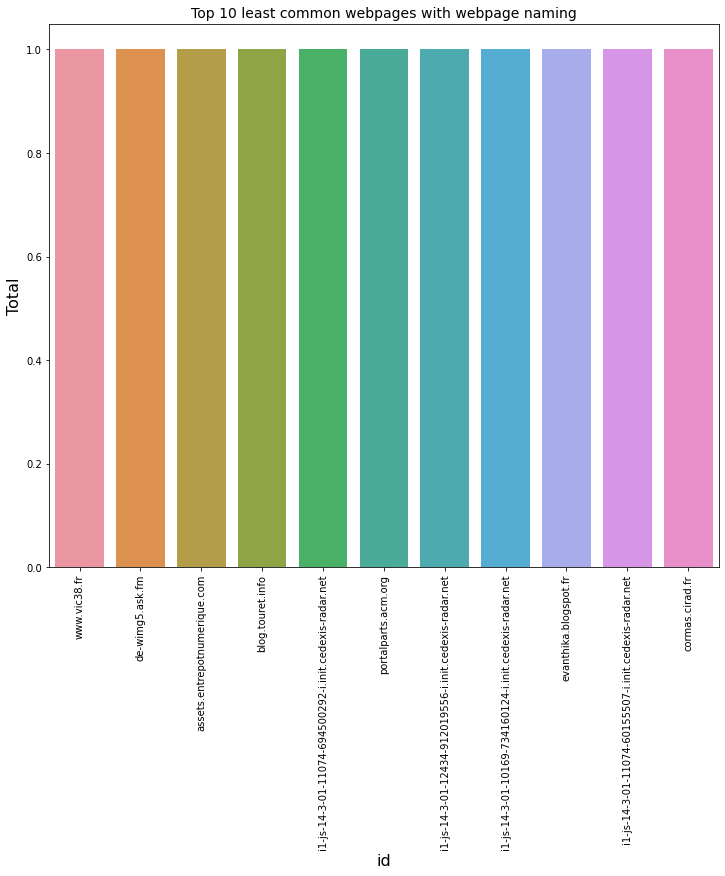

In [ ]:
#Review them in visualization for better comparison
fig16 = plt.figure(figsize=(12,10))

ax16 = sns.barplot(x="webpage", y="count", data=least_common)

plot_feature(ax3)

plt.xlabel("id", size=16)
plt.xticks(rotation=90, fontsize=10,horizontalalignment='center')
plt.ylabel("Total", size=16)


# title    
plt.title("Top 10 least common webpages with webpage naming", fontsize=14)


plt.show()

---

# Model Training

1. Train & Test set split
2. Normalization
3. Imbalanced Dataset handling
    - Resampling
    - SMOTE
4. Model Algorithm using Resampling and SMOTE
    - Random Forest
    - Ada Boost
    - Gradient Boosting
5. Inspect the algorithms with Confusion Matrix to see each of their performance
6. Further evaluate the models with Cross Validation to see the performance if is better or worsen.
7. Next inspect the dataset with the algorithms with Hyperparameter Tuning
8. Then look into the Features Importance (if needed)

## Train & Test set split

In [ ]:
X = df_train.drop(columns=["target"])
y = df_train["target"]

In [ ]:
print(X.shape, y.shape)

(159969, 19) (159969,)


In [ ]:
#Splitting into train and test set with also using stratify making sure in y sets have even group of the Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(111978, 19) (111978,)
(47991, 19) (47991,)


In [ ]:
X_train.head()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent
session_id,,,,,,,,,,,,,,,,,,,
140503,10812,10812.0,10812.0,10812.0,12892.0,10344.0,10344.0,0.0,0.0,0.0,3,3,10,13,2,2019,2,0.0,0.000000
158624,77957,581.0,568.0,1673.0,77944.0,77970.0,77983.0,607.0,529.0,607.0,0,9,12,20,11,2018,1,2.0,0.033333
59947,4130,4130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,1,9,22,11,2018,3,0.0,0.000000
115224,425,515849.0,438.0,515849.0,10708.0,659.0,12918.0,659.0,10708.0,451.0,0,7,14,22,2,2019,4,120.0,2.000000
87552,12385,11722.0,50163.0,50150.0,12398.0,0.0,0.0,0.0,0.0,0.0,5,5,8,12,2,2018,0,0.0,0.000000


In [ ]:
X_test.head()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent
session_id,,,,,,,,,,,,,,,,,,,
48407,63618,63566.0,10786.0,63618.0,72562.0,4338.0,529.0,425.0,4338.0,2193.0,0,8,9,24,2,2019,6,2.0,0.033333
119537,10708,2323.0,3662.0,8940.0,659.0,2323.0,4819.0,2323.0,136769.0,10708.0,0,7,11,29,1,2019,1,21.0,0.350000
124043,2453,2427.0,425.0,2427.0,2440.0,2466.0,802.0,2427.0,2453.0,776.0,0,7,11,17,2,2019,6,121.0,2.016667
157287,568,607.0,581.0,26542.0,529.0,181788.0,181788.0,181788.0,3662.0,425.0,0,8,8,24,2,2019,6,126.0,2.100000
77485,9681,9681.0,2362.0,9681.0,9681.0,2362.0,2362.0,25099.0,2362.0,9681.0,0,3,5,4,2,2019,0,21.0,0.350000


In [ ]:
y_train.value_counts()

0    110876
1      1102
Name: target, dtype: int64

In [ ]:
y_test.value_counts()

0    47518
1      473
Name: target, dtype: int64

### Data Normalization

In [ ]:
#Normalization is use after train_test_split in order to prevent data leakage

# Normalize the data between 0 to 1
scaler = MinMaxScaler()

# # For X
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [ ]:
%%time

rf_clf = RandomForestClassifier() 

rf_model = rf_clf.fit(X_train_norm, y_train)
rf_predict = rf_model.predict(X_test_norm)

rf_accuracy_score = rf_clf.score(X_test_norm, y_test)

print("\u0332".join("Evaluation Metrics with Random Forest Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_predict)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_predict, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_predict, average="macro")*100))


E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.36% 
Precision Score with Macro-averaged evaluation = 97.50% 
Recall Score with Macro-averaged evaluation = 68.49% 
F1 Score with Macro-averaged evaluation = 76.52% 
CPU times: user 19.6 s, sys: 8.76 ms, total: 19.6 s
Wall time: 19.6 s


### Handling Imbalanced Dataset

#### Resampling Method

In [ ]:
%%time

#Resample Minority class = Target no.1

# concatenate our training data back together
df_resample = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
major_resample = df_resample[df_resample.target !=1] #zero is majority
minor_resample = df_resample[df_resample.target ==1] #one is minority

#Resample not_Negative class

# upsample minority
minor_upsampled = resample(minor_resample,
                          replace=True, # sample with replacement
                          n_samples=len(major_resample), # match number in majority class
                          random_state=30) # reproducible results


# combine majority and upsampled minority
df_upsampled = pd.concat([major_resample, minor_upsampled]).sample(frac=1)

# check new class counts
print("Upsampled value counts:", df_upsampled.target.value_counts(), sep='\n')

print("\nUpsampled shape:", df_upsampled.shape)
print('\n')

"""
Assemble the resampled dataset for Model assess
"""
X_resampled_train = df_upsampled.drop('target', axis=1)
y_resampled_train = df_upsampled.target

#Data normalization with MinMaxScaler
X_resampled_train_norm = pd.DataFrame(scaler.fit_transform(X_resampled_train), columns=X_resampled_train.columns)
X_test_norm = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

#Random Forest Classifier
rf_upsampled_clf = RandomForestClassifier()
rf_upsampled_model = rf_upsampled_clf.fit(X_resampled_train_norm, y_resampled_train)
rf_upsampled_pred = rf_upsampled_model.predict(X_test_norm)


"""
Evaluation portion
"""

print("\u0332".join("Resample Evaluation Metrics with Random Forest Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_upsampled_pred)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_upsampled_pred, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_upsampled_pred, average="macro")*100))

Upsampled value counts:
1    110876
0    110876
Name: target, dtype: int64

Upsampled shape: (221752, 20)


R̲e̲s̲a̲m̲p̲l̲e̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.44% 
Precision Score with Macro-averaged evaluation = 94.47% 
Recall Score with Macro-averaged evaluation = 74.18% 
F1 Score with Macro-averaged evaluation = 81.27% 
CPU times: user 41.9 s, sys: 212 ms, total: 42.2 s
Wall time: 42.6 s


#### SMOTE (a.k.a Synthetic Minority Oversampling Technique)

In [ ]:
sm = SMOTE(random_state=27)
X_sm_train, y_sm_train = sm.fit_resample(X_train, y_train)

In [ ]:
%%time

rf_smote_clf = RandomForestClassifier()
rf_smote_model = rf_smote_clf.fit(X_sm_train, y_sm_train)

rf_smote_pred = rf_smote_model.predict(X_test)

"""
Evaluation portion
"""

print("\u0332".join("SMOTE Evaluation Metrics with Random Forest Classifier"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_smote_pred, average="macro")*100))

S̲M̲O̲T̲E̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
Accuracy Score = 99.33% 
Precision Score with Macro-averaged evaluation = 86.73% 
Recall Score with Macro-averaged evaluation = 74.54% 
F1 Score with Macro-averaged evaluation = 79.40% 
CPU times: user 1min 25s, sys: 170 ms, total: 1min 26s
Wall time: 1min 26s


#### Classification report

In [ ]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.96      0.38      0.55       473

    accuracy                           0.99     47991
   macro avg       0.98      0.69      0.77     47991
weighted avg       0.99      0.99      0.99     47991



In [ ]:
print(classification_report(y_test, rf_upsampled_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.92      0.48      0.63       473

    accuracy                           0.99     47991
   macro avg       0.96      0.74      0.82     47991
weighted avg       0.99      0.99      0.99     47991



In [ ]:
print(classification_report(y_test, rf_smote_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47518
           1       0.76      0.52      0.61       473

    accuracy                           0.99     47991
   macro avg       0.88      0.76      0.81     47991
weighted avg       0.99      0.99      0.99     47991



#### Confusion Matrix

[[47511     7]
 [  293   180]]


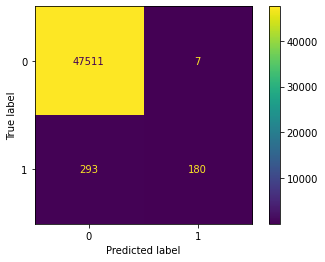

In [ ]:
# confusion_matrix before upsampled

rf_cm = confusion_matrix(y_test, rf_predict)

print(rf_cm)

rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_clf.classes_)

rf_disp.plot()
plt.show()

[[47498    20]
 [  244   229]]


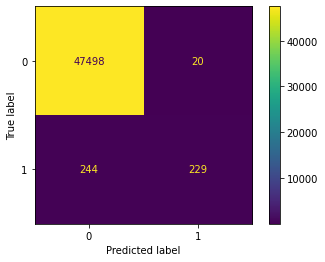

In [ ]:
# confusion_matrix after upsampled

rf_cm_resample = confusion_matrix(y_test, rf_upsampled_pred)

print(rf_cm_resample)

rf_resample_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_resample, display_labels=rf_upsampled_clf.classes_)

rf_resample_disp.plot()
plt.show()

[[47441    77]
 [  229   244]]


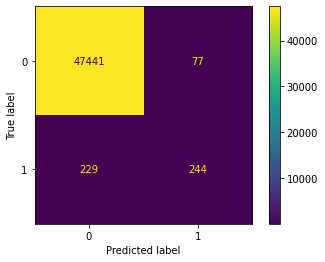

In [ ]:
# confusion_matrix after SMOTE handling

rf_cm_smote = confusion_matrix(y_test, rf_smote_pred)

print(rf_cm_smote)

rf_smote_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_smote, display_labels=rf_smote_clf.classes_)

rf_smote_disp.plot()
plt.show()

### <ins>Random Forest</ins>: Cross-validation

In [ ]:
#Setting up the K numbers of Fold
kf_rf = KFold(n_splits=5, random_state=111, shuffle=True) # Define the split - into 5 folds 
kf_rf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf_rf) 

KFold(n_splits=5, random_state=111, shuffle=True)


In [ ]:
%%time

# Perform 5-fold cross validation
rf_cv_scores = cross_val_score(rf_clf, X_train_norm, y_train, cv=kf_rf)
print("Random Forest Cross validation scores:", rf_cv_scores, sep='\n')

Random Forest Cross validation scores:
[0.99424004 0.99343633 0.99424004 0.9937486  0.99406117]
CPU times: user 1min 7s, sys: 230 ms, total: 1min 8s
Wall time: 1min 7s


In [ ]:
%%time

# Perform 5-fold cross validation with Resample set
rf_resample_cv_scores = cross_val_score(rf_upsampled_clf, X_resampled_train_norm, y_resampled_train, cv=kf_rf)
print("Random Forest Cross validation scores with Resample set:", rf_resample_cv_scores, sep='\n')

Random Forest Cross validation scores with Resample set:
[0.99966179 0.99966179 0.99959414 0.99968433 0.99968433]
CPU times: user 2min 28s, sys: 505 ms, total: 2min 28s
Wall time: 2min 28s


In [ ]:
%%time

# Perform 5-fold cross validation with smote set
rf_sm_cv_scores = cross_val_score(rf_smote_clf, X_sm_train, y_sm_train, cv=kf_rf)
print("Random Forest Cross validation scores with SMOTE set:", rf_sm_cv_scores, sep='\n')

Random Forest Cross validation scores with SMOTE set:
[0.99767762 0.99754233 0.99688839 0.99790304 0.99815107]
CPU times: user 5min 11s, sys: 540 ms, total: 5min 11s
Wall time: 5min 10s


## Hyperparameter tuning for Random Forest Classifier

In [ ]:
# RandomForestClassifier().get_params()

In [ ]:
#Function for Random Forest GridSearch CV

def gridSearch_rf(rf_classifier,rf_sub_title, rf_x_set, rf_y_set):


    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    # min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    # min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    parameters_rf = {'n_estimators': [100],
                   'max_features': max_features,
                   'max_depth': max_depth,
                  #  'min_samples_split': min_samples_split,
                  #  'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    gridSearch_rf = GridSearchCV(estimator = rf_classifier,
                                 param_grid = parameters_rf,
                                 scoring = 'accuracy',
                                 cv = 3,
                                 verbose = 2,
                                 n_jobs = -1)
    
    
    gridSearch_rf_model = gridSearch_rf.fit(rf_x_set, rf_y_set)
    
    

    best_accuracy_rf = gridSearch_rf_model.best_score_
    best_parameter_rf = gridSearch_rf_model.best_params_  
    
    print("\u0332".join(rf_sub_title), '\n')
    print("Best: %f using %s" % (best_accuracy_rf, best_parameter_rf))
    rf_means = gridSearch_rf.cv_results_['mean_test_score']
    rf_stds = gridSearch_rf.cv_results_['std_test_score']
    rf_params = gridSearch_rf.cv_results_['params']

    #prints the best result & the results from all combinations evaluated.
    for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
        print("%f (%f) with: %r" % (mean, stdev, param))

### Random Forest (Regular)

In [ ]:
#@title
%%time

gridSearch_rf(rf_clf ,"GridSearchCV Random Forest", X_train_norm, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t 

Best: 0.994204 using {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.992516 (0.000046) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.992525 (0.000022) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.993588 (0.000146) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
0.993731 (0.000079) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
0.993704 (0.000038) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100}
0.993624 (0.000058) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.993597 (0.000137) with: {'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 100}
0.993740 (0.000099) with

### Random Forest with Resampled Dataset

In [ ]:
%%time

#GridSearchCV using Resampled Dataset

gridSearch_rf(rf_upsampled_clf ,"GridSearchCV Random Forest with Resampling dataset", X_resampled_train_norm, y_resampled_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲w̲i̲t̲h̲ ̲R̲e̲s̲a̲m̲p̲l̲i̲n̲g̲ ̲d̲a̲t̲a̲s̲e̲t 

Best: 0.999775 using {'bootstrap': False, 'max_depth': 110, 'max_features': 'auto', 'n_estimators': 100}
0.980099 (0.001368) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.979770 (0.000764) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.996320 (0.000167) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
0.996207 (0.000017) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
0.999337 (0.000011) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100}
0.999414 (0.000023) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.999540 (0.000022) with: {'bootstrap': True, 'max_depth': 40, 'max_features': 'aut

### Random Forest with SMOTE Dataset

In [ ]:
%%time

#GridSearchCV using SMOTE Dataset

gridSearch_rf(rf_smote_clf ,"GridSearchCV Random Forest with SMOTE dataset", X_sm_train, y_sm_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲w̲i̲t̲h̲ ̲S̲M̲O̲T̲E̲ ̲d̲a̲t̲a̲s̲e̲t 

Best: 0.997592 using {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}
0.954787 (0.001972) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.954900 (0.003579) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.994837 (0.001170) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
0.994967 (0.001178) with: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
0.996888 (0.001585) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100}
0.996965 (0.001461) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.997136 (0.001584) with: {'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'n_est

## After GridSearchCV

### <ins>After GridSearchCV:</ins>  Random Forest

In [ ]:
%%time

rf_gs_clf = RandomForestClassifier(bootstrap = False, max_depth = 30, 
                                    max_features = 'sqrt', n_estimators = 100) 

rf_gs_model = rf_gs_clf.fit(X_train_norm, y_train)
rf_gs_predict = rf_gs_model.predict(X_test_norm)

print("\u0332".join("After Hyperparameter Tuning (GridSearch CV) with Random Forest Classifier"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_gs_predict)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_gs_predict, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_gs_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_gs_predict, average="macro")*100))

A̲f̲t̲e̲r̲ ̲H̲y̲p̲e̲r̲p̲a̲r̲a̲m̲e̲t̲e̲r̲ ̲T̲u̲n̲i̲n̲g̲ ̲(̲G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲ ̲C̲V̲)̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
Accuracy Score = 99.39% 
Precision Score with Macro-averaged evaluation = 97.67% 
Recall Score with Macro-averaged evaluation = 69.97% 
F1 Score with Macro-averaged evaluation = 78.06% 
CPU times: user 27.6 s, sys: 85.6 ms, total: 27.7 s
Wall time: 27.9 s


In [ ]:
print(classification_report(y_test, rf_gs_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.96      0.41      0.57       473

    accuracy                           0.99     47991
   macro avg       0.98      0.70      0.79     47991
weighted avg       0.99      0.99      0.99     47991



[[47510     8]
 [  279   194]]


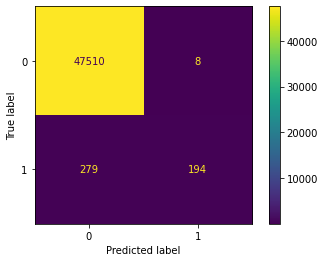

In [ ]:
# confusion_matrix before upsampled

rf_gs_cm = confusion_matrix(y_test, rf_gs_predict)

print(rf_gs_cm)

rf_gs_disp = ConfusionMatrixDisplay(confusion_matrix=rf_gs_cm, display_labels=rf_gs_clf.classes_)

rf_gs_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  Random Forest with Resampling Dataset

In [ ]:
%%time

#Random Forest Classifier
rf_gs_upsampled_clf = RandomForestClassifier(bootstrap = False, max_depth = 110, 
                                              max_features = 'auto', n_estimators = 100)

rf_gs_upsampled_model = rf_gs_upsampled_clf.fit(X_resampled_train_norm, y_resampled_train)
rf_gs_upsampled_pred = rf_gs_upsampled_model.predict(X_test_norm)


print("\u0332".join("After Hyperparameter Tuning (GridSearch CV) with Random Forest Classifier using Resampled Dataset"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_gs_upsampled_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_gs_upsampled_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_gs_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_gs_upsampled_pred, average="macro")*100))

A̲f̲t̲e̲r̲ ̲H̲y̲p̲e̲r̲p̲a̲r̲a̲m̲e̲t̲e̲r̲ ̲T̲u̲n̲i̲n̲g̲ ̲(̲G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲ ̲C̲V̲)̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲ ̲u̲s̲i̲n̲g̲ ̲R̲e̲s̲a̲m̲p̲l̲e̲d̲ ̲D̲a̲t̲a̲s̲e̲t
Accuracy Score = 99.43% 
Precision Score with Macro-averaged evaluation = 97.02% 
Recall Score with Macro-averaged evaluation = 72.19% 
F1 Score with Macro-averaged evaluation = 80.07% 
CPU times: user 59.4 s, sys: 163 ms, total: 59.6 s
Wall time: 59.9 s


In [ ]:
print(classification_report(y_test, rf_gs_upsampled_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.95      0.45      0.61       473

    accuracy                           0.99     47991
   macro avg       0.97      0.72      0.80     47991
weighted avg       0.99      0.99      0.99     47991



[[47507    11]
 [  262   211]]


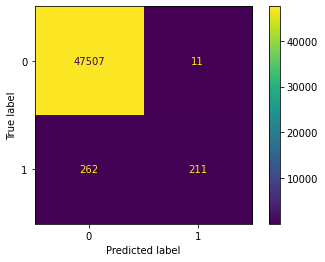

In [ ]:
# confusion_matrix after upsampled

rf_gs_cm_resample = confusion_matrix(y_test, rf_gs_upsampled_pred)

print(rf_gs_cm_resample)

rf_gs_resample_disp = ConfusionMatrixDisplay(confusion_matrix=rf_gs_cm_resample, display_labels=rf_gs_upsampled_clf.classes_)

rf_gs_resample_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  Random Forest with SMOTE Dataset

In [ ]:
%%time

rf_gs_smote_clf = RandomForestClassifier(bootstrap = False, max_depth = 100, 
                                         max_features = 'sqrt', n_estimators = 100)

rf_gs_smote_model = rf_gs_smote_clf.fit(X_sm_train, y_sm_train)

rf_gs_smote_pred = rf_gs_smote_model.predict(X_test)


print("\u0332".join("After Hyperparameter Tuning (GridSearch CV) with Random Forest Classifier using SMOTE Dataset"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, rf_gs_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, rf_gs_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, rf_gs_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, rf_gs_smote_pred, average="macro")*100))

A̲f̲t̲e̲r̲ ̲H̲y̲p̲e̲r̲p̲a̲r̲a̲m̲e̲t̲e̲r̲ ̲T̲u̲n̲i̲n̲g̲ ̲(̲G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲ ̲C̲V̲)̲ ̲w̲i̲t̲h̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲ ̲u̲s̲i̲n̲g̲ ̲S̲M̲O̲T̲E̲ ̲D̲a̲t̲a̲s̲e̲t
Accuracy Score = 99.35% 
Precision Score with Macro-averaged evaluation = 88.90% 
Recall Score with Macro-averaged evaluation = 73.61% 
F1 Score with Macro-averaged evaluation = 79.35% 
CPU times: user 2min 10s, sys: 227 ms, total: 2min 10s
Wall time: 2min 9s


In [ ]:
print(classification_report(y_test, rf_gs_smote_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.80      0.49      0.61       473

    accuracy                           0.99     47991
   macro avg       0.90      0.75      0.80     47991
weighted avg       0.99      0.99      0.99     47991



[[47460    58]
 [  240   233]]


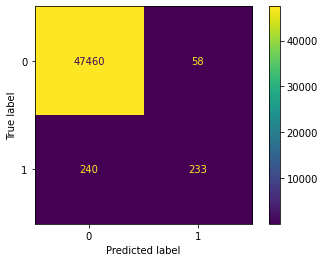

In [ ]:
# confusion_matrix after SMOTE handling

rf_gs_cm_smote = confusion_matrix(y_test, rf_gs_smote_pred)

print(rf_gs_cm_smote)

rf_gs_smote_disp = ConfusionMatrixDisplay(confusion_matrix=rf_gs_cm_smote, display_labels=rf_gs_smote_clf.classes_)

rf_gs_smote_disp.plot()
plt.show()

# AdaBoost

fabhsedr

In [ ]:
%%time

#AdaBoost (regular)

ada_clf = AdaBoostClassifier()

ada_model = ada_clf.fit(X_train_norm, y_train)
ada_predict = ada_model.predict(X_test_norm)

print("\u0332".join("Evaluation Metrics with AdaBoost Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_predict)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_predict, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_predict, average="macro")*100))

E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.12% 
Precision Score with Macro-averaged evaluation = 97.81% 
Recall Score with Macro-averaged evaluation = 55.81% 
F1 Score with Macro-averaged evaluation = 60.16% 
CPU times: user 8.63 s, sys: 77.8 ms, total: 8.7 s
Wall time: 8.67 s


### Handling Imbalanced Dataset for AdaBoost Modeling

#### Resampling Method for AdaBoost Classifier

In [ ]:
%%time

#Resample Minority class = Target no.1

# concatenate our training data back together
df_ada_resample = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
ada_major_resample = df_ada_resample[df_ada_resample.target !=1] #zero is majority
ada_minor_resample = df_ada_resample[df_ada_resample.target ==1] #one is minority

#Resample not_Negative class

# upsample minority
ada_minor_upsampled = resample(ada_minor_resample,
                          replace=True, # sample with replacement
                          n_samples=len(ada_major_resample), # match number in majority class
                          random_state=60) # reproducible results


# combine majority and upsampled minority
df_ada_upsampled = pd.concat([ada_major_resample, ada_minor_upsampled]).sample(frac=1)

# check new class counts
print("Upsampled value counts:", df_ada_upsampled.target.value_counts(), sep='\n')

print("\nUpsampled shape:", df_ada_upsampled.shape)
print('\n')

"""
Assemble the resampled dataset for Model assess
"""
X_ada_resampled_train = df_ada_upsampled.drop('target', axis=1)
y_ada_resampled_train = df_ada_upsampled.target

#Data normalization with MinMaxScaler
X_ada_resampled_train_norm = pd.DataFrame(scaler.fit_transform(X_ada_resampled_train), columns=X_ada_resampled_train.columns)
X_ada_test_norm = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

#Random Forest Classifier
ada_upsampled_clf = AdaBoostClassifier()
ada_upsampled_model = ada_upsampled_clf.fit(X_ada_resampled_train_norm, y_ada_resampled_train)
ada_upsampled_pred = ada_upsampled_model.predict(X_ada_test_norm)


"""
Evaluation portion
"""

print("\u0332".join("Resample Evaluation Metrics with AdaBoost Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_upsampled_pred)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_upsampled_pred, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_upsampled_pred, average="macro")*100))

Upsampled value counts:
1    110876
0    110876
Name: target, dtype: int64

Upsampled shape: (221752, 20)


R̲e̲s̲a̲m̲p̲l̲e̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 86.33% 
Precision Score with Macro-averaged evaluation = 52.98% 
Recall Score with Macro-averaged evaluation = 87.76% 
F1 Score with Macro-averaged evaluation = 52.00% 
CPU times: user 16.5 s, sys: 145 ms, total: 16.6 s
Wall time: 16.5 s


#### SMOTE (a.k.a Synthetic Minority Oversampling Technique) for AdaBoost Classifier

In [ ]:
%%time

sm = SMOTE(random_state=56)
X_ada_sm_train, y_ada_sm_train = sm.fit_resample(X_train, y_train)


#modeling
ada_smote_clf = AdaBoostClassifier()
ada_smote_model = ada_smote_clf.fit(X_ada_sm_train, y_ada_sm_train)

ada_smote_pred = ada_smote_model.predict(X_test)

"""
Evaluation portion
"""

print("\u0332".join("SMOTE Evaluation Metrics with AdaBoost Classifier"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_smote_pred, average="macro")*100))

S̲M̲O̲T̲E̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
Accuracy Score = 88.17% 
Precision Score with Macro-averaged evaluation = 52.64% 
Recall Score with Macro-averaged evaluation = 78.96% 
F1 Score with Macro-averaged evaluation = 52.03% 
CPU times: user 25.7 s, sys: 257 ms, total: 26 s
Wall time: 25.7 s


#### Classification report

In [ ]:
print(classification_report(y_test, ada_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.96      0.12      0.21       473

    accuracy                           0.99     47991
   macro avg       0.98      0.56      0.60     47991
weighted avg       0.99      0.99      0.99     47991



In [ ]:
print(classification_report(y_test, ada_upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     47518
           1       0.06      0.89      0.11       473

    accuracy                           0.86     47991
   macro avg       0.53      0.88      0.52     47991
weighted avg       0.99      0.86      0.92     47991



In [ ]:
print(classification_report(y_test, ada_smote_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     47518
           1       0.06      0.70      0.10       473

    accuracy                           0.88     47991
   macro avg       0.53      0.79      0.52     47991
weighted avg       0.99      0.88      0.93     47991



#### Confusion Matrix

[[47516     2]
 [  418    55]]


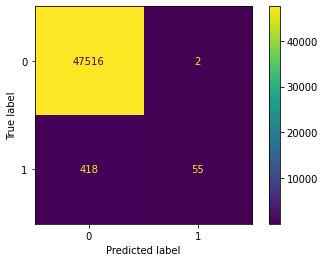

In [ ]:
# confusion_matrix before upsampled

ada_cm = confusion_matrix(y_test, ada_predict)

print(ada_cm)

ada_disp = ConfusionMatrixDisplay(confusion_matrix=ada_cm, display_labels=ada_clf.classes_)

ada_disp.plot()
plt.show()

[[41010  6508]
 [   51   422]]


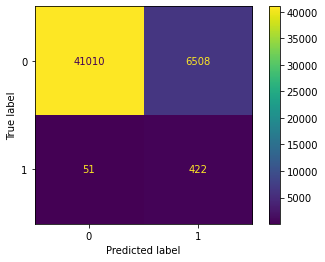

In [ ]:
# confusion_matrix after upsampled

ada_cm_resample = confusion_matrix(y_test, ada_upsampled_pred)

print(ada_cm_resample)

ada_resample_disp = ConfusionMatrixDisplay(confusion_matrix=ada_cm_resample, display_labels=ada_upsampled_clf.classes_)

ada_resample_disp.plot()
plt.show()

[[41987  5531]
 [  144   329]]


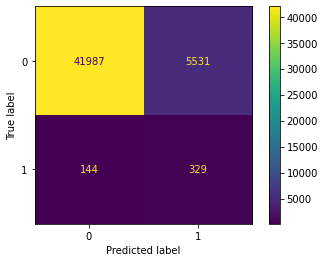

In [ ]:
# confusion_matrix after SMOTE handling

ada_cm_smote = confusion_matrix(y_test, ada_smote_pred)

print(ada_cm_smote)

ada_smote_disp = ConfusionMatrixDisplay(confusion_matrix=ada_cm_smote, display_labels=ada_smote_clf.classes_)

ada_smote_disp.plot()
plt.show()

### <ins>AdaBoost Classifier</ins>: Cross-validation

In [ ]:
#Setting up the K numbers of Fold
kf_ada = KFold(n_splits=5, random_state=222, shuffle=True) # Define the split - into 5 folds 
kf_ada.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf_ada) 

KFold(n_splits=5, random_state=222, shuffle=True)


In [ ]:
%%time

# Perform 5-fold cross validation
ada_cv_scores = cross_val_score(ada_clf, X_train_norm, y_train, cv=kf_ada)
print("AdaBoost Classifier Cross validation scores:", ada_cv_scores, sep='\n')

AdaBoost Classifier Cross validation scores:
[0.99066798 0.99115914 0.99124844 0.99151596 0.99151596]
CPU times: user 34 s, sys: 224 ms, total: 34.2 s
Wall time: 34 s


In [ ]:
%%time

# Perform 5-fold cross validation with Resample set
ada_resample_cv_scores = cross_val_score(ada_upsampled_clf, X_ada_resampled_train_norm, y_ada_resampled_train, cv=kf_ada)
print("AdaBoost Classifier Cross validation scores with Resample set:", ada_resample_cv_scores, sep='\n')

AdaBoost Classifier Cross validation scores with Resample set:
[0.88814232 0.88974319 0.8886133  0.88218715 0.88784667]
CPU times: user 1min 2s, sys: 359 ms, total: 1min 3s
Wall time: 1min 3s


In [ ]:
%%time

# Perform 5-fold cross validation with smote set
ada_sm_cv_scores = cross_val_score(ada_smote_clf, X_ada_sm_train, y_ada_sm_train, cv=kf_ada)
print("AdaBoost Classifier Cross validation scores with SMOTE set:", ada_sm_cv_scores, sep='\n')

AdaBoost Classifier Cross validation scores with SMOTE set:
[0.89941602 0.90212171 0.89483653 0.90139797 0.90085682]
CPU times: user 1min 37s, sys: 396 ms, total: 1min 37s
Wall time: 1min 37s


## Hyperparameter tuning for AdaBoost Classifier

In [ ]:
# AdaBoostClassifier().get_params()

In [ ]:
#Function for AdaBoost GridSearch CV

def gridSearch_ada(ada_classifier, ada_sub_title, ada_x_set, ada_y_set):
    
#     # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
    # explore learning rates from 0.1 to 2 in 0.1 increments
    learning_rate = [x for x in np.arange(0.1, 2.1, 0.1)]
    
    parameters_ada = {'n_estimators': [100],
                     'algorithm': ['SAMME','SAMME.R'],
                     'base_estimator': [None],
                     'learning_rate': learning_rate
                    }

    gridSearch_ada = GridSearchCV(estimator = ada_classifier,
                                 param_grid = parameters_ada,
                                 scoring = 'accuracy',
                                 cv = 3,
                                 verbose = 2,
                                 n_jobs = -1)
    
    
    gridSearch_ada_model = gridSearch_ada.fit(ada_x_set, ada_y_set)
    
    
    best_accuracy_ada = gridSearch_ada_model.best_score_
    best_parameter_ada = gridSearch_ada_model.best_params_  
    
    print("\u0332".join(ada_sub_title), '\n')
    print("Best: %f using %s" % (best_accuracy_ada, best_parameter_ada))
    ada_means = gridSearch_ada.cv_results_['mean_test_score']
    ada_stds = gridSearch_ada.cv_results_['std_test_score']
    ada_params = gridSearch_ada.cv_results_['params']

    #prints the best result & the results from all combinations evaluated.
    for mean, stdev, param in zip(ada_means, ada_stds, ada_params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time

#GridSearch CV for regular AdaBoost Classifier
gridSearch_ada(ada_clf, "GridSearchCV on Regular AdaBoost Classifier", X_train_norm, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲R̲e̲g̲u̲l̲a̲r̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r 

Best: 0.991543 using {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.3000000000000003, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.2, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.30000000000000004, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.4, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.5, 'n_estimators': 100}
0.990159 (0.000013) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.6, 'n_estimators': 100}
0.990159 (

In [ ]:
%%time

#GridSearch CV for AdaBoost Classifier with Resampled Dataset
gridSearch_ada(ada_upsampled_clf, "GridSearchCV on Regular AdaBoost Classifier with Resampled Dataset", X_ada_resampled_train_norm, y_ada_resampled_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲R̲e̲g̲u̲l̲a̲r̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲ ̲w̲i̲t̲h̲ ̲R̲e̲s̲a̲m̲p̲l̲e̲d̲ ̲D̲a̲t̲a̲s̲e̲t 

Best: 0.919031 using {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.6, 'n_estimators': 100}
0.804304 (0.001763) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 100}
0.806473 (0.001188) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.2, 'n_estimators': 100}
0.813824 (0.003329) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.30000000000000004, 'n_estimators': 100}
0.821855 (0.002563) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.4, 'n_estimators': 100}
0.828989 (0.001879) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.5, 'n_estimators': 100}
0.834049 (0.000982) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.6, 

In [ ]:
%%time

#GridSearch CV for AdaBoost Classifier with SMOTE Dataset
gridSearch_ada(ada_smote_clf, "GridSearchCV on Regular AdaBoost Classifier with SMOTE Dataset", X_ada_sm_train, y_ada_sm_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲R̲e̲g̲u̲l̲a̲r̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲ ̲w̲i̲t̲h̲ ̲S̲M̲O̲T̲E̲ ̲D̲a̲t̲a̲s̲e̲t 

Best: 0.931166 using {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.7000000000000002, 'n_estimators': 100}
0.796620 (0.000669) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 100}
0.829476 (0.001077) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.2, 'n_estimators': 100}
0.846297 (0.000848) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.30000000000000004, 'n_estimators': 100}
0.851081 (0.000300) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.4, 'n_estimators': 100}
0.852682 (0.000984) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.5, 'n_estimators': 100}
0.858856 (0.001386) with: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate'

## After GridSearchCV

### <ins>After GridSearchCV:</ins>  AdaBoost

In [ ]:
%%time

#AdaBoost (regular)

ada_gs_clf = AdaBoostClassifier(algorithm = 'SAMME.R', base_estimator = None, 
                                learning_rate = 1.30, n_estimators = 100)

ada_gs_model = ada_gs_clf.fit(X_train_norm, y_train)
ada_gs_predict = ada_gs_model.predict(X_test_norm)

print("\u0332".join("Evaluation Metrics with AdaBoost Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_gs_predict)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_gs_predict, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_gs_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_gs_predict, average="macro")*100))

E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.16% 
Precision Score with Macro-averaged evaluation = 86.93% 
Recall Score with Macro-averaged evaluation = 60.85% 
F1 Score with Macro-averaged evaluation = 66.65% 
CPU times: user 17.7 s, sys: 132 ms, total: 17.8 s
Wall time: 17.7 s


In [ ]:
print(classification_report(y_test, ada_gs_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.75      0.22      0.34       473

    accuracy                           0.99     47991
   macro avg       0.87      0.61      0.67     47991
weighted avg       0.99      0.99      0.99     47991



[[47483    35]
 [  370   103]]


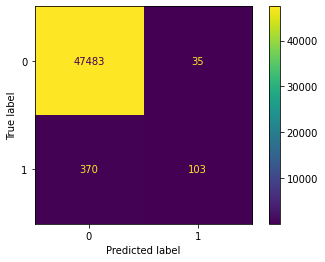

In [ ]:
# confusion_matrix before upsampled

ada_gs_cm = confusion_matrix(y_test, ada_gs_predict)

print(ada_gs_cm)

ada_gs_disp = ConfusionMatrixDisplay(confusion_matrix=ada_gs_cm, display_labels=ada_gs_clf.classes_)

ada_gs_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  Resampling Dataset with AdaBoost Classifier

In [ ]:
%%time

#AdaBoost Classifier
ada_gs_upsampled_clf = AdaBoostClassifier(algorithm ='SAMME.R', base_estimator = None, 
                                          learning_rate = 1.60, n_estimators = 100)
ada_gs_upsampled_model = ada_gs_upsampled_clf.fit(X_ada_resampled_train_norm, y_ada_resampled_train)
ada_gs_upsampled_pred = ada_gs_upsampled_model.predict(X_ada_test_norm)


"""
Evaluation portion
"""

print("\u0332".join("Resample Evaluation Metrics with AdaBoost Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_gs_upsampled_pred)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_gs_upsampled_pred, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_gs_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_gs_upsampled_pred, average="macro")*100))

R̲e̲s̲a̲m̲p̲l̲e̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 89.43% 
Precision Score with Macro-averaged evaluation = 53.93% 
Recall Score with Macro-averaged evaluation = 90.69% 
F1 Score with Macro-averaged evaluation = 54.50% 
CPU times: user 32.5 s, sys: 185 ms, total: 32.7 s
Wall time: 32.6 s


In [ ]:
print(classification_report(y_test, ada_gs_upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     47518
           1       0.08      0.92      0.15       473

    accuracy                           0.89     47991
   macro avg       0.54      0.91      0.55     47991
weighted avg       0.99      0.89      0.94     47991



[[42483  5035]
 [   38   435]]


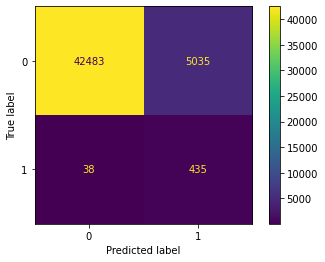

In [ ]:
# confusion_matrix after upsampled

ada_gs_cm_resample = confusion_matrix(y_test, ada_gs_upsampled_pred)

print(ada_gs_cm_resample)

ada_gs_resample_disp = ConfusionMatrixDisplay(confusion_matrix=ada_gs_cm_resample, display_labels=ada_gs_upsampled_clf.classes_)

ada_gs_resample_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  SMOTE Dataset with AdaBoost Classifier

In [ ]:
%%time

#modeling
ada_gs_smote_clf = AdaBoostClassifier(algorithm ='SAMME.R', base_estimator = None, 
                                        learning_rate = 1.70, n_estimators = 100)
ada_gs_smote_model = ada_gs_smote_clf.fit(X_ada_sm_train, y_ada_sm_train)

ada_gs_smote_pred = ada_gs_smote_model.predict(X_test)

"""
Evaluation portion
"""

print("\u0332".join("SMOTE Evaluation Metrics with AdaBoost Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, ada_gs_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, ada_gs_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, ada_gs_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, ada_gs_smote_pred, average="macro")*100))

S̲M̲O̲T̲E̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 92.02% 
Precision Score with Macro-averaged evaluation = 53.67% 
Recall Score with Macro-averaged evaluation = 78.49% 
F1 Score with Macro-averaged evaluation = 54.80% 
CPU times: user 50.7 s, sys: 221 ms, total: 50.9 s
Wall time: 50.8 s


In [ ]:
print(classification_report(y_test, ada_gs_smote_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     47518
           1       0.08      0.65      0.14       473

    accuracy                           0.92     47991
   macro avg       0.54      0.78      0.55     47991
weighted avg       0.99      0.92      0.95     47991



[[43857  3661]
 [  167   306]]


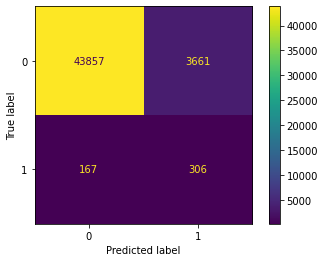

In [ ]:
# confusion_matrix after SMOTE handling

ada_gs_cm_smote = confusion_matrix(y_test, ada_gs_smote_pred)

print(ada_gs_cm_smote)

ada_gs_smote_disp = ConfusionMatrixDisplay(confusion_matrix=ada_gs_cm_smote, display_labels=ada_gs_smote_clf.classes_)

ada_gs_smote_disp.plot()
plt.show()

# Gradient Boosting

fabhsedr

In [ ]:
%%time

#Gradient Boosting (regular)

gb_clf = GradientBoostingClassifier()

gb_model = gb_clf.fit(X_train_norm, y_train)
gb_predict = gb_model.predict(X_test_norm)

print("\u0332".join("Evaluation Metrics with Gradient Boosting Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_predict)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_predict, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_predict, average="macro")*100))

E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.21% 
Precision Score with Macro-averaged evaluation = 98.11% 
Recall Score with Macro-averaged evaluation = 60.25% 
F1 Score with Macro-averaged evaluation = 66.73% 
CPU times: user 41.3 s, sys: 22.3 ms, total: 41.3 s
Wall time: 46.5 s


### Handling Imbalanced Dataset for Gradient Boosting Modeling

#### Resampling Method for Gradient Boosting Classifier

In [ ]:
%%time

#Resample Minority class = Target no.1

# concatenate our training data back together
df_gb_resample = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
gb_major_resample = df_gb_resample[df_gb_resample.target !=1] #zero is majority
gb_minor_resample = df_gb_resample[df_gb_resample.target ==1] #one is minority

#Resample not_Negative class

# upsample minority
gb_minor_upsampled = resample(gb_minor_resample,
                          replace=True, # sample with replacement
                          n_samples=len(gb_major_resample), # match number in majority class
                          random_state=99) # reproducible results


# combine majority and upsampled minority
df_gb_upsampled = pd.concat([gb_major_resample, gb_minor_upsampled]).sample(frac=1)

# check new class counts
print("Upsampled value counts:", df_gb_upsampled.target.value_counts(), sep='\n')

print("\nUpsampled shape:", df_gb_upsampled.shape)
print('\n')

"""
Assemble the resampled dataset for Model assess
"""
X_gb_resampled_train = df_gb_upsampled.drop('target', axis=1)
y_gb_resampled_train = df_gb_upsampled.target

#Data normalization with MinMaxScaler
X_gb_resampled_train_norm = pd.DataFrame(scaler.fit_transform(X_gb_resampled_train), columns=X_gb_resampled_train.columns)
X_gb_test_norm = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

#Random Forest Classifier
gb_upsampled_clf = GradientBoostingClassifier()
gb_upsampled_model = gb_upsampled_clf.fit(X_gb_resampled_train_norm, y_gb_resampled_train)
gb_upsampled_pred = gb_upsampled_model.predict(X_gb_test_norm)


"""
Evaluation portion
"""

print("\u0332".join("Resample Evaluation Metrics with Gradient Boosting Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_upsampled_pred)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_upsampled_pred, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_upsampled_pred, average="macro")*100))

Upsampled value counts:
1    110876
0    110876
Name: target, dtype: int64

Upsampled shape: (221752, 20)


R̲e̲s̲a̲m̲p̲l̲e̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 91.38% 
Precision Score with Macro-averaged evaluation = 54.93% 
Recall Score with Macro-averaged evaluation = 93.55% 
F1 Score with Macro-averaged evaluation = 56.71% 
CPU times: user 1min 11s, sys: 179 ms, total: 1min 11s
Wall time: 1min 11s


#### SMOTE (a.k.a Synthetic Minority Oversampling Technique) for Gradient Classifier

In [ ]:
%%time

gb_sm = SMOTE(random_state=86)
X_gb_sm_train, y_gb_sm_train = gb_sm.fit_resample(X_train, y_train)


#modeling
gb_smote_clf = GradientBoostingClassifier()
gb_smote_model = gb_smote_clf.fit(X_gb_sm_train, y_gb_sm_train)

gb_smote_pred = gb_smote_model.predict(X_test)

"""
Evaluation portion
"""

print("\u0332".join("SMOTE Evaluation Metrics with Gradient Boosting Classifier"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_smote_pred, average="macro")*100))

S̲M̲O̲T̲E̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
Accuracy Score = 93.47% 
Precision Score with Macro-averaged evaluation = 55.03% 
Recall Score with Macro-averaged evaluation = 83.51% 
F1 Score with Macro-averaged evaluation = 57.36% 
CPU times: user 1min 59s, sys: 289 ms, total: 1min 59s
Wall time: 2min


#### Classification report

In [ ]:
print(classification_report(y_test, gb_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47518
           1       0.97      0.21      0.34       473

    accuracy                           0.99     47991
   macro avg       0.98      0.60      0.67     47991
weighted avg       0.99      0.99      0.99     47991



In [ ]:
print(classification_report(y_test, gb_upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     47518
           1       0.10      0.96      0.18       473

    accuracy                           0.91     47991
   macro avg       0.55      0.94      0.57     47991
weighted avg       0.99      0.91      0.95     47991



In [ ]:
print(classification_report(y_test, gb_smote_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     47518
           1       0.10      0.73      0.18       473

    accuracy                           0.93     47991
   macro avg       0.55      0.84      0.57     47991
weighted avg       0.99      0.93      0.96     47991



#### Confusion Matrix

[[47515     3]
 [  376    97]]


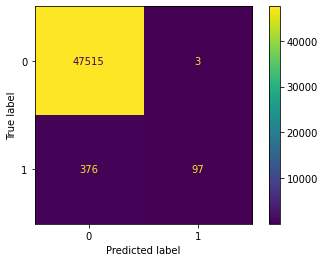

In [ ]:
# confusion_matrix before upsampled

gb_cm = confusion_matrix(y_test, gb_predict)

print(gb_cm)

gb_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=gb_clf.classes_)

gb_disp.plot()
plt.show()

[[43401  4117]
 [   20   453]]


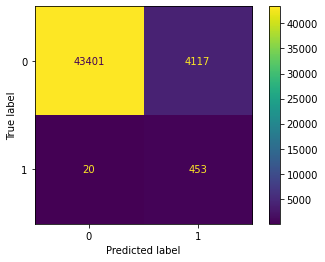

In [ ]:
# confusion_matrix after upsampled

gb_cm_resample = confusion_matrix(y_test, gb_upsampled_pred)

print(gb_cm_resample)

gb_resample_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm_resample, display_labels=gb_upsampled_clf.classes_)

gb_resample_disp.plot()
plt.show()

[[44508  3010]
 [  126   347]]


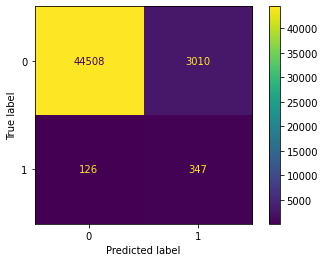

In [ ]:
# confusion_matrix after SMOTE handling

gb_cm_smote = confusion_matrix(y_test, gb_smote_pred)

print(gb_cm_smote)

gb_smote_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm_smote, display_labels=gb_smote_clf.classes_)

gb_smote_disp.plot()
plt.show()

### <ins>Gradient Boosting Classifier</ins>: Cross-validation

In [ ]:
#Setting up the K numbers of Fold
kf_gb = KFold(n_splits=5, random_state=222, shuffle=True) # Define the split - into 5 folds 
kf_gb.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf_gb) 

KFold(n_splits=5, random_state=222, shuffle=True)


In [ ]:
%%time

# Perform 5-fold cross validation
gb_cv_scores = cross_val_score(gb_clf, X_train_norm, y_train, cv=kf_gb)
print("Gradient Boosting Classifier Cross validation scores:", gb_cv_scores, sep='\n')

Gradient Boosting Classifier Cross validation scores:
[0.99205215 0.99316842 0.99276657 0.99348069 0.99303416]
CPU times: user 2min 24s, sys: 314 ms, total: 2min 24s
Wall time: 2min 23s


In [ ]:
%%time

# Perform 5-fold cross validation with Resample set
gb_resample_cv_scores = cross_val_score(gb_upsampled_clf, X_gb_resampled_train_norm, y_gb_resampled_train, cv=kf_gb)
print("Gradient Boosting Cross validation scores with Resample set:", gb_resample_cv_scores, sep='\n')

Gradient Boosting Cross validation scores with Resample set:
[0.94058759 0.93544678 0.94435175 0.93524239 0.93988726]
CPU times: user 4min 20s, sys: 433 ms, total: 4min 21s
Wall time: 4min 19s


In [ ]:
%%time

# Perform 5-fold cross validation with smote set
gb_sm_cv_scores = cross_val_score(gb_smote_clf, X_gb_sm_train, y_gb_sm_train, cv=kf_gb)
print("Gradient Boosting Cross validation scores with SMOTE set:", gb_sm_cv_scores, sep='\n')

Gradient Boosting Cross validation scores with SMOTE set:
[0.93301166 0.93725057 0.93183766 0.93425028 0.93573844]
CPU times: user 7min 27s, sys: 594 ms, total: 7min 28s
Wall time: 7min 26s


## Hyperparameter tuning for Gradient Boosting Classifier

In [ ]:
# GradientBoostingClassifier().get_params()

In [ ]:
#Function for Gradient Boosting GridSearch CV

def gridSearch_gb(gb_classifier, gb_sub_title, gb_x_set, gb_y_set):
    
    # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
    # Number of features to consider at every split
    # max_features = ['auto', 'sqrt']
    # explore learning rates from 0.1 to 2 in 0.1 increments
    learning_rate = [x for x in np.arange(0.1, 2.1, 0.1)]
    criterion =['friedman_mse','squared_error']
    loss = ['deviance','exponential']
    # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#     max_depth.append(None)
    # Minimum number of samples required to split a node
    # min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    # min_samples_leaf = [1, 2, 4]
    
    
    parameters_gb = {'n_estimators': [100],
                    #  'max_features' : max_features,
                     'learning_rate': learning_rate,
                      'criterion' : criterion,
                      'loss' : loss,
#                       'max_depth' : max_depth,
                      # 'min_samples_split' : min_samples_split,
                      # 'min_samples_leaf' : min_samples_leaf
                    }

    gridSearch_gb = GridSearchCV(estimator = gb_classifier,
                                 param_grid = parameters_gb,
                                 cv = 3,
                                 verbose = 2,
                                 n_jobs = -1)
    
    
    gridSearch_gb_model = gridSearch_gb.fit(gb_x_set, gb_y_set)
    
    

    best_accuracy_gb = gridSearch_gb_model.best_score_
    best_parameter_gb = gridSearch_gb_model.best_params_  
    
    print("\u0332".join(gb_sub_title), '\n')
    print("Best: %f using %s" % (best_accuracy_gb, best_parameter_gb))
    gb_means = gridSearch_gb.cv_results_['mean_test_score']
    gb_stds = gridSearch_gb.cv_results_['std_test_score']
    gb_params = gridSearch_gb.cv_results_['params']

    #prints the best result & the results from all combinations evaluated.
    for mean, stdev, param in zip(gb_means, gb_stds, gb_params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time

#GridSearch CV for regular Gradient Boosting Classifier
gridSearch_gb(gb_clf, "GridSearchCV on Regular Gradient Boosting", X_train_norm, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲R̲e̲g̲u̲l̲a̲r̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g 

Best: 0.995187 using {'criterion': 'friedman_mse', 'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 100}
0.992981 (0.000122) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100}
0.990668 (0.000103) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
0.994079 (0.000306) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'n_estimators': 100}
0.992820 (0.000179) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 100}
0.994490 (0.000182) with: {'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'loss': 'deviance', 'n_estimators': 100}
0.993722 (0.000166) with: {'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'loss': 'exponential', 'n_

In [ ]:
%%time

#GridSearch CV for Gradient Boosting Classifier with Resampled Dataset
gridSearch_gb(gb_upsampled_clf, "GridSearchCV on Gradient Boosting with Resampled Dataset", X_gb_resampled_train_norm, y_gb_resampled_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲R̲e̲s̲a̲m̲p̲l̲e̲d̲ ̲D̲a̲t̲a̲s̲e̲t 

Best: 0.994444 using {'criterion': 'friedman_mse', 'learning_rate': 1.3000000000000003, 'loss': 'deviance', 'n_estimators': 100}
0.939861 (0.003432) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100}
0.941439 (0.000266) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
0.972131 (0.000843) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'n_estimators': 100}
0.971396 (0.001196) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 100}
0.980929 (0.000228) with: {'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'loss': 'deviance', 'n_estimators': 100}
0.979509 (0.000457) with: {'criterion': 'friedman_mse', 'learning_rate': 0.300

In [ ]:
%%time

#GridSearch CV for Gradient Boosting Classifier with SMOTE Dataset
gridSearch_gb(gb_smote_clf, "GridSearchCV on Gradient Boosting with SMOTE Dataset", X_gb_sm_train, y_gb_sm_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V̲ ̲o̲n̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲S̲M̲O̲T̲E̲ ̲D̲a̲t̲a̲s̲e̲t 

Best: 0.988677 using {'criterion': 'friedman_mse', 'learning_rate': 1.2000000000000002, 'loss': 'deviance', 'n_estimators': 100}
0.933439 (0.000655) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 100}
0.933385 (0.000823) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
0.961263 (0.000772) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'n_estimators': 100}
0.959306 (0.001126) with: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 100}
0.972302 (0.001177) with: {'criterion': 'friedman_mse', 'learning_rate': 0.30000000000000004, 'loss': 'deviance', 'n_estimators': 100}
0.970187 (0.001767) with: {'criterion': 'friedman_mse', 'learning_rate': 0.30000000000

## After GridSearchCV

### <ins>After GridSearchCV:</ins>  Gradient Boosting

In [ ]:
%%time

#Gradient Boosting (regular)

gb_gs_clf = GradientBoostingClassifier(  criterion = 'friedman_mse', loss = 'exponential',
                                learning_rate = 0.8, n_estimators = 100)

gb_gs_model = gb_gs_clf.fit(X_train_norm, y_train)
gb_gs_predict = gb_gs_model.predict(X_test_norm)

print("\u0332".join("Evaluation Metrics with Gradient Boosting Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_gs_predict)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_gs_predict, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_gs_predict, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_gs_predict, average="macro")*100))

E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 99.45% 
Precision Score with Macro-averaged evaluation = 91.23% 
Recall Score with Macro-averaged evaluation = 77.64% 
F1 Score with Macro-averaged evaluation = 83.07% 
CPU times: user 38.3 s, sys: 93.4 ms, total: 38.4 s
Wall time: 39 s


In [ ]:
print(classification_report(y_test, gb_gs_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47518
           1       0.83      0.55      0.66       473

    accuracy                           0.99     47991
   macro avg       0.91      0.78      0.83     47991
weighted avg       0.99      0.99      0.99     47991



[[47464    54]
 [  211   262]]


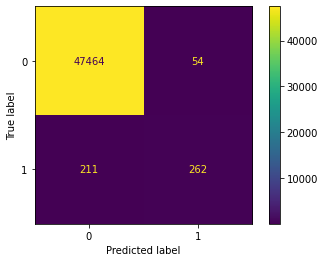

In [ ]:
# confusion_matrix before upsampled

gb_gs_cm = confusion_matrix(y_test, gb_gs_predict)

print(gb_gs_cm)

gb_gs_disp = ConfusionMatrixDisplay(confusion_matrix=gb_gs_cm, display_labels=gb_gs_clf.classes_)

gb_gs_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  Resampling Dataset with Gradient Boosting Classifier

In [ ]:
%%time

#Gradient Boosting Classifier
gb_gs_upsampled_clf = GradientBoostingClassifier(criterion ='friedman_mse', loss = 'deviance', 
                                          learning_rate = 1.30, n_estimators = 100)
gb_gs_upsampled_model = gb_gs_upsampled_clf.fit(X_gb_resampled_train_norm, y_gb_resampled_train)
gb_gs_upsampled_pred = gb_gs_upsampled_model.predict(X_gb_test_norm)


"""
Evaluation portion
"""

print("\u0332".join("Resample Evaluation Metrics with Gradient Boosting Classifier:"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_gs_upsampled_pred)*100))

    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_gs_upsampled_pred, average="macro")*100))
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_gs_upsampled_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_gs_upsampled_pred, average="macro")*100))

R̲e̲s̲a̲m̲p̲l̲e̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r̲:
Accuracy Score = 98.78% 
Precision Score with Macro-averaged evaluation = 71.87% 
Recall Score with Macro-averaged evaluation = 91.64% 
F1 Score with Macro-averaged evaluation = 78.56% 
CPU times: user 1min 19s, sys: 159 ms, total: 1min 19s
Wall time: 1min 25s


In [ ]:
print(classification_report(y_test, gb_gs_upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     47518
           1       0.44      0.84      0.58       473

    accuracy                           0.99     47991
   macro avg       0.72      0.92      0.79     47991
weighted avg       0.99      0.99      0.99     47991



[[47008   510]
 [   74   399]]


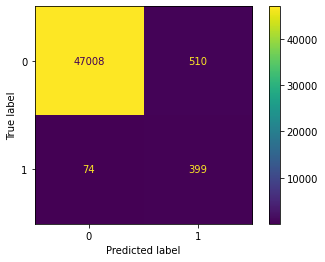

In [ ]:
# confusion_matrix after upsampled

gb_gs_cm_resample = confusion_matrix(y_test, gb_gs_upsampled_pred)

print(gb_gs_cm_resample)

gb_gs_resample_disp = ConfusionMatrixDisplay(confusion_matrix=gb_gs_cm_resample, display_labels=gb_gs_upsampled_clf.classes_)

gb_gs_resample_disp.plot()
plt.show()

### <ins>After GridSearchCV:</ins>  SMOTE Dataset with Gradient Boosting Classifier

In [ ]:
%%time

#modeling
gb_gs_smote_clf = GradientBoostingClassifier(criterion ='friedman_mse', loss = 'deviance', 
                                            learning_rate = 1.20, n_estimators = 100)

gb_gs_smote_model = gb_gs_smote_clf.fit(X_gb_sm_train, y_gb_sm_train)

gb_gs_smote_pred = gb_gs_smote_model.predict(X_test)

"""
Evaluation portion
"""

print("\u0332".join("SMOTE Evaluation Metrics with Gradient Boosting Classifier"))
# Checking accuracy
print("Accuracy Score = {:.2f}% ".format(accuracy_score(y_test, gb_gs_smote_pred)*100))
    
#precision score
print("Precision Score with Macro-averaged evaluation = {:.2f}% ".format(precision_score(y_test, gb_gs_smote_pred, average="macro")*100)) 
    
# recall score    
print("Recall Score with Macro-averaged evaluation = {:.2f}% ".format(recall_score(y_test, gb_gs_smote_pred, average="macro")*100))

# f1 score
print("F1 Score with Macro-averaged evaluation = {:.2f}% ".format(f1_score(y_test, gb_gs_smote_pred, average="macro")*100))

S̲M̲O̲T̲E̲ ̲E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ ̲w̲i̲t̲h̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
Accuracy Score = 98.51% 
Precision Score with Macro-averaged evaluation = 68.08% 
Recall Score with Macro-averaged evaluation = 83.76% 
F1 Score with Macro-averaged evaluation = 73.45% 
CPU times: user 1min 57s, sys: 147 ms, total: 1min 57s
Wall time: 1min 58s


In [ ]:
print(classification_report(y_test, gb_gs_smote_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     47518
           1       0.36      0.69      0.48       473

    accuracy                           0.99     47991
   macro avg       0.68      0.84      0.73     47991
weighted avg       0.99      0.99      0.99     47991



[[46952   566]
 [  148   325]]


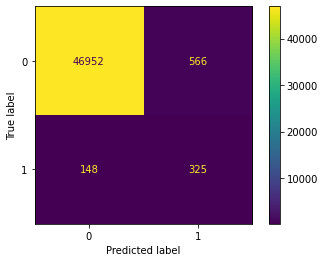

In [ ]:
# confusion_matrix after SMOTE handling

gb_gs_cm_smote = confusion_matrix(y_test, gb_gs_smote_pred)

print(gb_gs_cm_smote)

gb_gs_smote_disp = ConfusionMatrixDisplay(confusion_matrix=gb_gs_cm_smote, display_labels=gb_gs_smote_clf.classes_)

gb_gs_smote_disp.plot()
plt.show()

## Metric AUC-ROC with **visualisation**

Here we using the AUC-ROC metric to inspect the models in order to conclude the findings.

In [ ]:
# roc curve for models

#Random Forest Classifier
fpr1, tpr1, thresh1 = roc_curve(y_test, rf_gs_predict, pos_label=1)

#Random Forest Classifier with Resampled Dataset
fpr2, tpr2, thresh2 = roc_curve(y_test, rf_gs_upsampled_pred, pos_label=1)

#Random Forest Classifier with SMOTE Dataset
fpr3, tpr3, thresh3 = roc_curve(y_test, rf_gs_smote_pred, pos_label=1)

In [ ]:
# AdaBoost Classifier
fpr4, tpr4, thresh4 = roc_curve(y_test, ada_gs_predict, pos_label=1)

# AdaBoost Classifier with Resampled Dataset
fpr5, tpr5, thresh5 = roc_curve(y_test, ada_gs_upsampled_pred, pos_label=1)

# AdaBoost Classifier with SMOTE Dataset
fpr6, tpr6, thresh6 = roc_curve(y_test, ada_gs_smote_pred, pos_label=1)

In [ ]:
# Gradient Boosting Classifier
fpr7, tpr7, thresh7 = roc_curve(y_test, gb_gs_predict, pos_label=1)

# Gradient Boosting Classifier with Resampled Dataset
fpr8, tpr8, thresh8 = roc_curve(y_test, gb_gs_upsampled_pred, pos_label=1)

# Gradient Boosting Classifier with SMOTE Dataset
fpr9, tpr9, thresh9 = roc_curve(y_test, gb_gs_smote_pred, pos_label=1)

In [ ]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

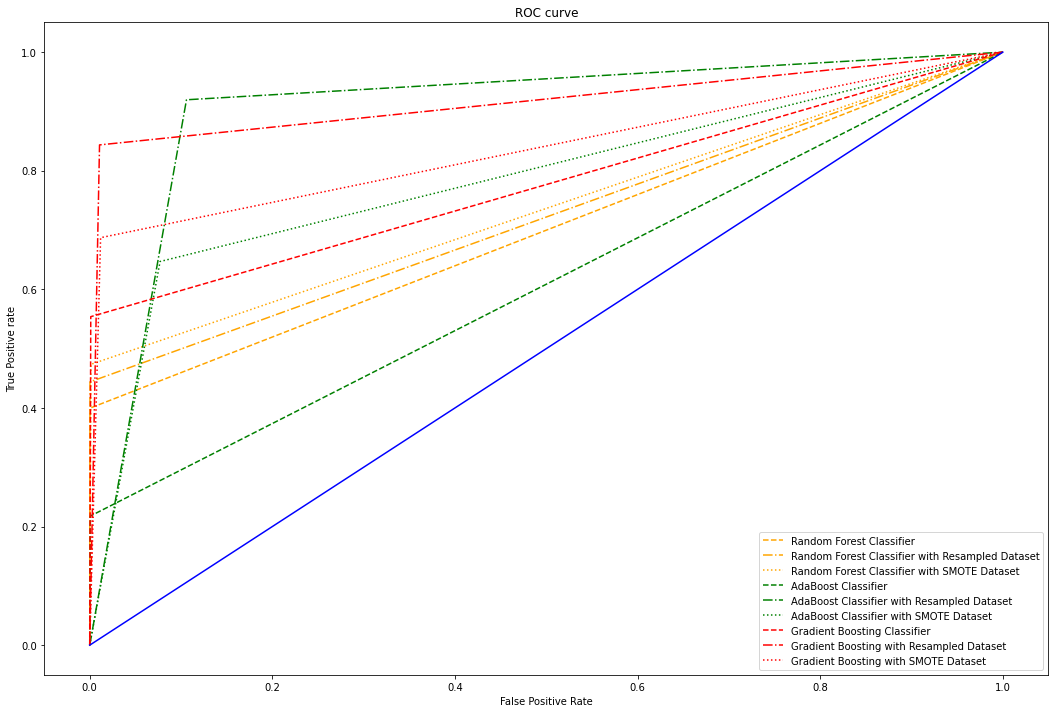

In [ ]:
#Plots

fig = plt.figure(figsize=(18,12))

# plot roc curves for Random Forest Classifier
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest Classifier')
plt.plot(fpr2, tpr2, linestyle='dashdot',color='orange', label='Random Forest Classifier with Resampled Dataset')
plt.plot(fpr3, tpr3, linestyle='dotted',color='orange', label='Random Forest Classifier with SMOTE Dataset')


# plot roc curves for AdaBoost Classifier
plt.plot(fpr4, tpr4, linestyle='--',color='green', label='AdaBoost Classifier')
plt.plot(fpr5, tpr5, linestyle='dashdot',color='green', label='AdaBoost Classifier with Resampled Dataset')
plt.plot(fpr6, tpr6, linestyle='dotted',color='green', label='AdaBoost Classifier with SMOTE Dataset')


# plot roc curves for Gradient Boosting Classifier
plt.plot(fpr7, tpr7, linestyle='--',color='red', label='Gradient Boosting Classifier')
plt.plot(fpr8, tpr8, linestyle='dashdot',color='red', label='Gradient Boosting with Resampled Dataset')
plt.plot(fpr9, tpr9, linestyle='dotted',color='red', label='Gradient Boosting with SMOTE Dataset')

# plot of roc curve for tpr = fpr 
plt.plot(p_fpr, p_tpr, linestyle='solid', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

In [131]:
#AUC Score

"""
Random Forest Classifier AUC Scores
"""
rf_auc_score = roc_auc_score(y_test, rf_gs_predict)

#AUC Score for Classifier with Resampled Dataset
rf_upsampled_auc_score = roc_auc_score(y_test, rf_gs_upsampled_pred)

#AUC Score for Classifier with SMOTE Dataset
rf_smote_auc_score = roc_auc_score(y_test, rf_gs_smote_pred)


print("\u0332".join("AUC Score for Random Forest Classifier"))
print("AUC score for Random Forest Classifier:{:.2f}%".format(rf_auc_score*100))
print("AUC score for Random Forest Classifier with Resampled Dataset:{:.2f}%".format(rf_upsampled_auc_score*100))
print("AUC score for Random Forest Classifier with SMOTE Dataset:{:.2f}%".format(rf_smote_auc_score*100))

print('\n')



"""
AdaBoost Classifier AUC Scores
"""
ada_auc_score = roc_auc_score(y_test, ada_gs_predict)

#AUC Score for AdaBoost Classifier with Resampled Dataset
ada_upsampled_auc_score = roc_auc_score(y_test, ada_gs_upsampled_pred)

#AUC Score for AdaBoost Classifier with SMOTE Dataset
ada_smote_auc_score = roc_auc_score(y_test, ada_gs_smote_pred)


print("\u0332".join("AUC Score for AdaBoost Classifier"))
print("AUC score for AdaBoost Classifier:{:.2f}%".format(ada_auc_score*100))
print("AUC score for AdaBoost Classifier with Resampled Dataset:{:.2f}%".format(ada_upsampled_auc_score*100))
print("AUC score for AdaBoost Classifier with SMOTE Dataset:{:.2f}%".format(ada_smote_auc_score*100))

print('\n')


"""
Gradient Boosting Classifier AUC Scores
"""
gb_auc_score = roc_auc_score(y_test, gb_gs_predict)

#AUC Score for Gradient Boosting Classifier with Resampled Dataset
gb_upsampled_auc_score = roc_auc_score(y_test, gb_gs_upsampled_pred)

#AUC Score for Gradient Boosting Classifier with SMOTE Dataset
gb_smote_auc_score = roc_auc_score(y_test, gb_gs_smote_pred)


print("\u0332".join("AUC Score for Gradient Boosting Classifier"))
print("AUC score for Gradient Boosting Classifier:{:.2f}%".format(gb_auc_score*100))
print("AUC score for Gradient Boosting Classifier with Resampled Dataset:{:.2f}%".format(gb_upsampled_auc_score*100))
print("AUC score for Gradient Boosting Classifier with SMOTE Dataset:{:.2f}%".format(gb_smote_auc_score*100))

print('\n')


A̲U̲C̲ ̲S̲c̲o̲r̲e̲ ̲f̲o̲r̲ ̲R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
AUC score for Random Forest Classifier:69.97%
AUC score for Random Forest Classifier with Resampled Dataset:72.19%
AUC score for Random Forest Classifier with SMOTE Dataset:73.61%


A̲U̲C̲ ̲S̲c̲o̲r̲e̲ ̲f̲o̲r̲ ̲A̲d̲a̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
AUC score for AdaBoost Classifier:60.85%
AUC score for AdaBoost Classifier with Resampled Dataset:90.69%
AUC score for AdaBoost Classifier with SMOTE Dataset:78.49%


A̲U̲C̲ ̲S̲c̲o̲r̲e̲ ̲f̲o̲r̲ ̲G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r
AUC score for Gradient Boosting Classifier:77.64%
AUC score for Gradient Boosting Classifier with Resampled Dataset:91.64%
AUC score for Gradient Boosting Classifier with SMOTE Dataset:83.76%




## Ingest the given test set to prediction for submission


In [ ]:
# prediction rows - for Kaggle submission (export as CSV)

In [ ]:
df_test

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,nans_count,n_unique_pages,hour,day,month,year,day_of_week,first_last_diff,minutes_spent
session_id,,,,,,,,,,,,,,,,,,,
0,10318,10318.0,10318.0,10318.0,10318.0,10318.0,10318.0,10318.0,10318.0,10318.0,0,1,6,28,3,2019,3,270.0,4.500000
1,438,2453.0,2427.0,2466.0,2453.0,2466.0,2427.0,2453.0,2453.0,2466.0,0,4,6,28,2,2019,3,246.0,4.100000
2,7562,425.0,7562.0,425.0,425.0,0.0,0.0,0.0,0.0,0.0,5,2,11,18,3,2019,0,0.0,0.000000
3,8836,12372.0,12398.0,12385.0,12385.0,12398.0,12372.0,451.0,425.0,438.0,0,7,12,17,3,2019,6,45.0,0.750000
4,451,9863.0,451.0,9889.0,451.0,425.0,9928.0,867.0,880.0,867.0,0,7,9,31,3,2019,6,1110.0,18.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93333,659,111380.0,13659.0,10708.0,7562.0,13659.0,10214.0,10708.0,2323.0,2323.0,0,7,10,27,2,2019,2,108.0,1.800000
93334,1153,1127.0,1153.0,1127.0,867.0,880.0,867.0,1140.0,1127.0,1192.0,0,6,7,24,3,2019,6,14.0,0.233333
93335,13659,10708.0,13659.0,10214.0,13659.0,10214.0,13659.0,10214.0,13659.0,0.0,1,3,10,26,3,2019,1,0.0,0.000000


In [ ]:
new_test_set = scaler.fit_transform(df_test)
new_test_set

array([[1.87839723e-02, 1.90792831e-02, 1.90774487e-02, ...,
        5.00000000e-01, 1.50000000e-01, 1.50000000e-01],
       [5.05074799e-04, 4.53590633e-03, 4.48739757e-03, ...,
        5.00000000e-01, 1.36666667e-01, 1.36666667e-01],
       [1.36851219e-02, 7.85878594e-04, 1.39817472e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.49651258e-02, 1.98004423e-02, 2.52547851e-02, ...,
        1.66666667e-01, 0.00000000e+00, 0.00000000e+00],
       [5.72321901e-01, 2.84303138e-02, 3.53149129e-04, ...,
        0.00000000e+00, 1.44444444e-02, 1.44444444e-02],
       [8.40372312e-01, 3.46322828e-02, 8.40158418e-01, ...,
        5.00000000e-01, 1.66666667e-03, 1.66666667e-03]])

In [ ]:
%%time

#Gradient Boosting Classifier with Resampled Dataset
new_upsampled_clf = GradientBoostingClassifier(criterion ='friedman_mse', loss = 'deviance', 
                                          learning_rate = 1.30, n_estimators = 100)
new_upsampled_model = new_upsampled_clf.fit(X_gb_resampled_train_norm, y_gb_resampled_train)
new_upsampled_pred = new_upsampled_model.predict(new_test_set)


new_upsampled_pred

CPU times: user 1min 13s, sys: 182 ms, total: 1min 14s
Wall time: 1min 14s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
predict = pd.DataFrame()
predict["target"] = new_upsampled_pred

In [ ]:
predict

,target
0,0
1,0
2,0
3,1
4,0
...,...
93333,0
93334,0
93335,0
93336,0


In [ ]:
predict.shape

(93338, 1)

In [ ]:
predict.value_counts()

target
0         92582
1           756
dtype: int64

In [ ]:
predict.index.names = ['session_id']

In [ ]:
predict

,target
session_id,
0,0
1,0
2,0
3,1
4,0
...,...
93333,0
93334,0
93335,0


In [ ]:
predict.to_csv(r'/content/drive/MyDrive/Official DS training Files/Classification part 3/Prediction_Submission - Yvonne_Gan.csv')

In [132]:
#AdaBoost Classifier
new_ada_upsampled_clf = AdaBoostClassifier(algorithm ='SAMME.R', base_estimator = None, 
                                          learning_rate = 1.60, n_estimators = 100)
new_ada_upsampled_model = new_ada_upsampled_clf.fit(X_ada_resampled_train_norm, y_ada_resampled_train)
new_ada_upsampled_pred = new_ada_upsampled_model.predict(new_test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [133]:
ada_predict = pd.DataFrame()
ada_predict["target"] = new_ada_upsampled_pred

ada_predict.index.names = ['session_id']

In [136]:
ada_predict.shape

(93338, 1)

In [134]:
ada_predict.value_counts()

target
0         83618
1          9720
dtype: int64

In [140]:
ada_predict.to_csv(r'/content/drive/MyDrive/Official DS training Files/Classification part 3/Prediction_Submission_AdaBoost - Yvonne_Gan.csv')

## Summary & Conclusions